# Figs for Paper

## Contact Matrices

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np
plt.rcParams.update({'font.size': 24}) 








New Dataset 










FileNotFoundError: [Errno 2] No such file or directory: 'contact_mats/cm_comix1_sbm.pdf'

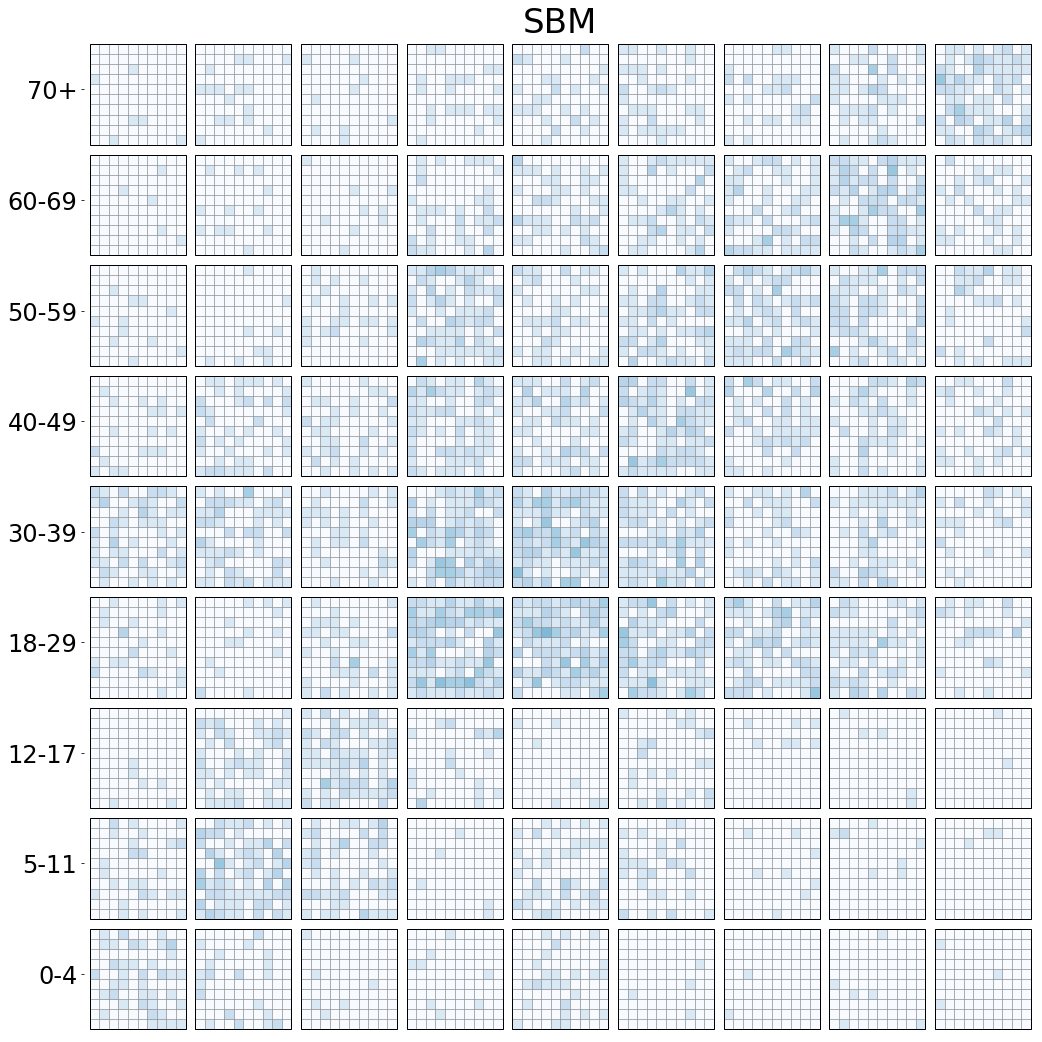

In [11]:
datas = ['CoMix_p1', 'CoMix_p2', 'polymod_df']
data_titles = ['CoMix 1', 'CoMix 2', 'POLYMOD']
egos = ['comix1', 'comix2', 'poly']
models = ['sbm','dpln', 'data']
model_names = ['SBM', 'dPlN', 'Data']

num_rows, epsilon = 9, 1e-1
width = 1/(num_rows+epsilon*num_rows)
num_small = 10
max_degree = 100
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
num_samples = num_small**2
cmap_grey = plt.get_cmap('Greys')
inside_g, outside_g = 0.1,0.5

for data_idx, data in enumerate(egos):
    print(f'\n\n\n\n\n\n\nNew Dataset \n\n\n\n\n\n\n\n')
    for model_idx, model in enumerate(models): 
        
        if model =='data':
            with open(f'output_data/egos/egos_{egos[data_idx]}.json') as f:
                ego_networks = json.load(f)
            print(f'{data} {model}: {np.mean([a["degree"] for a in ego_networks])}')
            ## count the partitions of data set
            data_partitions = np.zeros(len(partitions))
            for ego in ego_networks:
                data_partitions[ego['age']] += 1
            # make cumulative
            data_partitions = np.cumsum(data_partitions)
            # randomly sample in partitions
            samples = np.zeros((len(partitions), len(partitions), num_samples))
            for i, top in enumerate(data_partitions):
                for j, _ in enumerate(data_partitions):
                    if i == 0:    
                        indices = np.random.randint(0, top, size=num_samples)
                    else:
                        indices = np.random.randint(data_partitions[i-1], top, size=num_samples)
                    for k, idx in enumerate(indices):
                        # print(f'shape: {np.shape(samples)} \ni: {i}\nj: {j}\nk: {k}\n idx: {idx}\nlen(egos): {len(ego_networks)}\n {len(ego_networks[idx]["contacts"])}')
                        samples[i,j,k] = ego_networks[idx]['contacts'][j]
                        
        else:  
            # read in the example network
            with open(f'output_data/egos/{data}_{model}.json') as f:
                network = json.load(f)

            #preprocessing
            # randomly sample in partitions
            samples = np.zeros((len(partitions), len(partitions), num_samples))
            for i, top in enumerate(partitions):
                for j, _ in enumerate(partitions):
                    if i == 0:    
                        indices = np.random.randint(0, top, size=num_samples)
                    else:
                        indices = np.random.randint(partitions[i-1], top, size=num_samples)
                    for k, idx in enumerate(indices):
                        samples[i, j, k] = network['frequency_distribution'][idx][j]

        if data != egos[0] and model != models[0]:
            fig, ax = plt.subplots(figsize=(17,17))
        elif data != egos[0]:
            fig, ax = plt.subplots(figsize=(17,15)) 
        elif model != models[0]:
            fig, ax = plt.subplots(figsize=(15,17))           
        else:
            fig, ax = plt.subplots(figsize=(15,15))
        # cmap = plt.get_cmap('viridis')
        if model == models[0]:
            cmap = plt.get_cmap('Blues')
        elif model == models[1]:
            cmap = plt.get_cmap('Greens')
        else:
            # cmap =plt.get_cmap('OrRd')
            cmap=plt.get_cmap('binary')
        
        max_val_test = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # shuffle to make it prettier
                box_samples = samples[i,j,:]
                np.random.shuffle(box_samples)
                for k in range(num_small):
                    for l in range(num_small):
                        # small squares
                        if box_samples[k*num_small + l] >= max_val_test:
                            max_val_test = box_samples[k*num_small + l]
                            # print(max_val_test)
                        # linear (pretty bad)
                        # norm_degree = box_samples[k*num_small + l] / max_degree if box_samples[k*num_small + l] < max_degree else (max_degree-1)/max_degree
                        # square root (pretty good)
                        # norm_degree = np.sqrt(box_samples[k*num_small + l] / max_degree) if box_samples[k*num_small + l] < max_degree else np.sqrt((max_degree-1)/max_degree)
                        # log scale
                        norm_degree = (np.log(box_samples[k*num_small + l]+1) - np.log(1)) / (np.log(max_degree+1) - np.log(1)) if box_samples[k*num_small + l] < max_degree else (max_degree-1)/max_degree
                        #green colorbar too light. change in colorbar too
                        if model == models[1]:
                            if norm_degree != 0:
                                norm_degree = norm_degree**0.8
                        # norm_degree = norm_degree**0.9
                        
                        colour = cmap(norm_degree)
                        rect = patches.Rectangle(((i+epsilon/2)/num_rows + k*width/num_small, (j+epsilon/2)/num_rows + l*width/num_small), width/num_small, width/num_small, linewidth=0.5, edgecolor='grey', facecolor=colour)
                        grey = cmap_grey(inside_g)
                        # rect = patches.Rectangle(((i+epsilon/2)/num_rows + k*width/num_small, (j+epsilon/2)/num_rows + l*width/num_small), width/num_small, width/num_small, linewidth=0.5, edgecolor=grey, facecolor=colour)
                        
                        ax.add_patch(rect)
                # big squares
                grey = cmap_grey(outside_g)
                # rect = patches.Rectangle(((i+epsilon/2)/num_rows, (j+epsilon/2)/num_rows), width, width, linewidth=1, edgecolor=grey, facecolor='none')
                rect = patches.Rectangle(((i+epsilon/2)/num_rows, (j+epsilon/2)/num_rows), width, width, linewidth=1, edgecolor='k', facecolor='none')
                ax.add_patch(rect)
                
        buckets = ['0-4', '5-11', '12-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70+']
        plt.xticks(rotation=60)
        ax.set_xticks([(i + (1 + epsilon)/2)/num_rows for i in range(num_rows)], buckets)
        ax.set_yticks([(i + (1 + epsilon)/2)/num_rows for i in range(num_rows)], buckets)
        # ax.tick_params(color='white')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if data == egos[0]:
            plt.title(f'{model_names[model_idx]}', fontsize=34)
        #     for index in range(len(model_names)):
        #         if model == models[-1]:
        #             plt.title(f'{data_titles[data_idx]}: {model_names[index]}', fontsize=40)
        #         if models[index] == model:
        #             plt.title(f'{model_names[index]}', fontsize=40) 
        # plt.title(f'{data_titles[data_idx]}')
        # plt.title(f'{model_names[model_idx]}')
        
        if data != egos[2]:
            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if model != models[0]:
            plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelleft=False)
        
            
        # plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'cm_{data}_{model}.pdf', format='pdf')
        plt.show()

## Errors

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns




n-Binomial: 1.8400139284434651
dPlN: 1.3893767128415213
SBM: 3.00609522524454
n-Binomial: 1.8400139284434651
dPlN: 1.3893767128415213
SBM: 3.00609522524454
n-Binomial: 1.8400139284434651
dPlN: 1.3893767128415213
SBM: 3.00609522524454


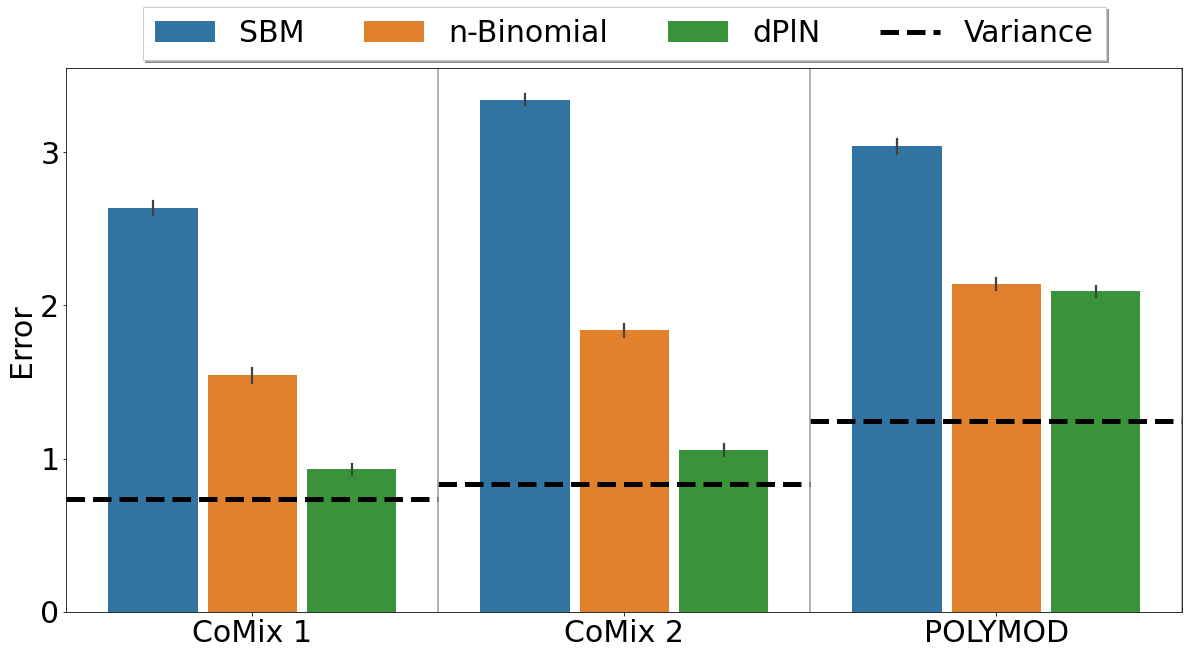

In [4]:
datas = ['comix1', 'comix2', 'poly']
models = ['sbm', 'nbinom', 'dpln']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
model_names = ['SBM', 'n-Binomial', 'dPlN']

df, var = pd.DataFrame({}), pd.DataFrame({})
for i, data in enumerate(datas):
    for j, model in enumerate(models):
        try:
            tmp = np.loadtxt(f'output_data/errors/{data}_{model}.csv', delimiter=',')
            df = pd.concat([df, pd.DataFrame({'Error': tmp, 'Model': [f'{model_names[j]}' for _ in range(len(tmp))], 'Data': [f'{data_names[i]}' for _ in range(len(tmp))]})])
        except:
            print(f'oops no output_data/errors/{data}_{model}.csv')
        try: 
            tmp_var = np.loadtxt(f'output_data/errors/itself_{data}_{model}.csv', delimiter=',')
            var = pd.concat([var, pd.DataFrame({'Error': tmp_var, 'Model': [f'{model_names[j]}' for _ in range(len(tmp_var))], 'Data': [f'{data_names[i]}' for _ in range(len(tmp_var))]})])
        except:
            print(f'')

plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
df_reduced = df[df['Model'] != 'Reconstruction']

sns.barplot(data=df_reduced, x='Data', y='Error', hue='Model',errorbar=('sd',3), gap=0.1)

for data in data_names:
    df_less = df_reduced[df_reduced['Data'] == data]
    for key in set(df_reduced['Model']):
        print(f"{key}: {np.mean(df_reduced[df_reduced['Model'] == key]['Error'])}")
        
## variance line
for i, data in enumerate(data_names):
    var_less = var[var['Data'] == data]
    mean = np.mean(var_less['Error'])
    plt.plot([-1/2+i,1/2+i],[mean, mean], '--k', linewidth = 5, label='Variance' if i==0 else '') 

# sns.violinplot(data=df_reduced, x='Data', y='Error', hue='Model')
# sns.boxplot(data=df, x='Data', y='Error', hue='Model')
# plt.yscale('log')

for pos in range(3):  # Skip the last position
    plt.axvline(x=pos+1/2, color='gray', alpha=0.6, linewidth=2)
    # print(pos, np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error']))
    # plt.plot([pos-1/2+2e-3, pos+1/2-5e-3], [np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error']), np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error'])], 'k--', label='Model Variance' if pos==0 else '', linewidth=5)
plt.xlim([-1/2, 5/2])
plt.xlabel('')

plt.yticks([0,1,2,3])
# plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=4, fancybox=False, shadow=True)
# plt.savefig('error_plots.pdf', bbox_inches='tight')

plt.show()

## Duration Scaling

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

df_c1 = pd.read_csv('input_data/comix1.csv', delimiter=',')
df_c2 = pd.read_csv('input_data/comix2.csv', delimiter=',')

############################################### CoMix 1 ########################################################'
bin_centers, bin_tops = [], [1,5,15,60,60*4,60*24]
for i, top in enumerate(bin_tops[1:]):
    gmean = sc.stats.mstats.gmean(list(range(bin_tops[i], top)))
    bin_centers.append(gmean)
    #try lower bounds
    # bin_centers.append(bin_tops[i])

bin_centers.append(bin_centers[0])
 

dur_counts_c1, freq_counts_c1 = np.zeros((len(set(df_c1['part_id'])), 6)), np.zeros((len(set(df_c1['part_id'])), 6)) 
for part_index, part_id in enumerate(set(df_c1['part_id'])):
    df_tmp = df_c1[df_c1['part_id'] == part_id]
    for _, row in df_tmp.iterrows():
        if np.isnan(row['duration_multi']):
            dur_counts_c1[part_index, -1] += 1
        else:
            dur_counts_c1[part_index, int(row['duration_multi'])-1] += 1
        
        if np.isnan(row['frequency_multi']):
            freq_counts_c1[part_index, -1] += 1
        else:
            freq_counts_c1[part_index, int(row['frequency_multi'])-1] += 1
            

xs, ys = [], []
for person in dur_counts_c1:
    if sum(person[:-1]) >0:
        xs.append(sum(person))
        ys.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
    
# sort lists 
# Pair each element with its original index using enumerate
indexed_list = list(enumerate(xs)) 

# Sort the list by the elements while keeping the original indices
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])

# Extract the sorted elements and their original indices
sorted_xs = np.array([element for _, element in sorted_indexed_list])
original_indices = [index for index, _ in sorted_indexed_list]

sorted_ys = np.array([ys[original_indices[i]]/(60) for i, x in enumerate(xs)])
xs = list(range(1, int(max(sorted_xs))+1))
x_counts, ys = np.zeros(int(max(sorted_xs))), np.zeros(int(max(sorted_xs))) 

for i, y in enumerate(sorted_ys):
    x_counts[int(sorted_xs[i])-1] += 1
    ys[int(sorted_xs[i])-1] += y
    
############# try binning data ############

tmp, first, x_bins, x_tops = 0, 1, [], []
for i,x in enumerate(x_counts):
    tmp += x
    if tmp > 5:
        x_tops.append(i+1)    
        x_bins.append(sc.stats.mstats.gmean(list(range(first,i+2))))
        first = i+2
        tmp = 0

y_bins = np.zeros(len(x_tops)) 
for i, x_top in enumerate(x_tops):
    tmp_num, tmp_sum = 0, 0 
    for idx in range(0 if i==0 else x_tops[i-1], x_top):
        tmp_num += x_counts[idx]
        tmp_sum += ys[idx]
    y_bins[i] = tmp_sum/tmp_num

x_c1,y_c1,x_c1_counts = xs, ys/x_counts, x_counts

## binned
x_c1_bins, y_c1_bins = x_bins, y_bins

############################################## CoMix 2 ######################################################

dur_counts_c2, freq_counts_c2 = np.zeros((len(set(df_c2['part_id'])), 6)), np.zeros((len(set(df_c2['part_id'])), 6)) 
for part_index, part_id in enumerate(set(df_c2['part_id'])):
    df_tmp = df_c2[df_c2['part_id'] == part_id]
    for _, row in df_tmp.iterrows():
        if np.isnan(row['duration_multi']):
            dur_counts_c2[part_index, -1] += 1
        else:
            dur_counts_c2[part_index, int(row['duration_multi'])-1] += 1
        
        if np.isnan(row['frequency_multi']):
            freq_counts_c2[part_index, -1] += 1
        else:
            freq_counts_c2[part_index, int(row['frequency_multi'])-1] += 1
            

xs, ys = [], []
for person in dur_counts_c2:
    if sum(person[:-1]) >0:
        xs.append(sum(person))
        ys.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
    
# sort lists 
# Pair each element with its original index using enumerate
indexed_list = list(enumerate(xs)) 

# Sort the list by the elements while keeping the original indices
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])

# Extract the sorted elements and their original indices
sorted_xs = np.array([element for _, element in sorted_indexed_list])
original_indices = [index for index, _ in sorted_indexed_list]

sorted_ys = np.array([ys[original_indices[i]]/(60) for i, x in enumerate(xs)])
xs = list(range(1, int(max(sorted_xs))+1))
x_counts, ys = np.zeros(int(max(sorted_xs))), np.zeros(int(max(sorted_xs))) 

for i, y in enumerate(sorted_ys):
    x_counts[int(sorted_xs[i])-1] += 1
    ys[int(sorted_xs[i])-1] += y
    
    
############# try binning data ############

tmp, first, x_bins, x_tops = 0, 1, [], []
for i,x in enumerate(x_counts):
    tmp += x
    if tmp > 5:
        x_tops.append(i+1)    
        x_bins.append(sc.stats.mstats.gmean(list(range(first,i+2))))
        first = i+2
        tmp = 0

y_bins = np.zeros(len(x_tops)) 
for i, x_top in enumerate(x_tops):
    tmp_num, tmp_sum = 0, 0 
    for idx in range(0 if i==0 else x_tops[i-1], x_top):
        tmp_num += x_counts[idx]
        tmp_sum += ys[idx]
    y_bins[i] = tmp_sum/tmp_num
    
x_c2,y_c2, x_c2_counts = xs, ys/x_counts, x_counts

## binned
x_c2_bins, y_c2_bins = x_bins, y_bins

/tmp/ipykernel_20884/2406342283.py:79: RuntimeWarning: invalid value encountered in divide
  x_c1,y_c1,x_c1_counts = xs, ys/x_counts, x_counts
/tmp/ipykernel_20884/2406342283.py:146: RuntimeWarning: invalid value encountered in divide
  x_c2,y_c2, x_c2_counts = xs, ys/x_counts, x_counts


0.0 0.0006850398760138171
[ 1.92956894e-01  2.59704669e-01  3.80034378e+04  9.99807691e-01
 -3.79945575e+04]
[ 5.93873598e-02  1.81042228e-01  1.06873503e+05  9.99929091e-01
 -1.06864101e+05]


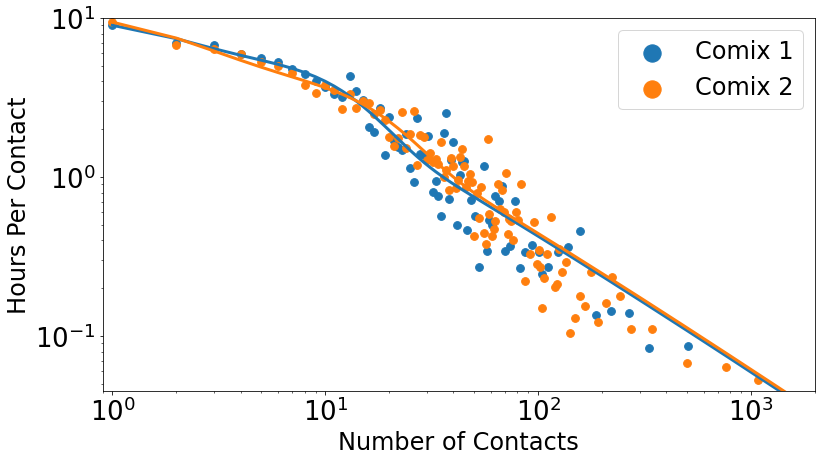

In [18]:
plt.rcParams.update({'font.size': 26})

def curve3(x, A, B, C, D, E):
    x = np.array(x)
    return A*np.exp(-B*x)*np.power(x,2) + C/np.power(x,D) + E/x 


x = list(range(1,max(x_c2)))
data, durations = [], []
for person in dur_counts_c1:
    if sum(person[:-1]) >0:
        data.append(sum(person))
        durations.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
for person in dur_counts_c2:
    if sum(person[:-1]) >0:
        data.append(sum(person))
        durations.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])


## Remove Nans from data
x_c1 = [i for i, x in zip(x_c1 , y_c1) if not np.isnan(x)]
y_c1 = [a for a in y_c1 if not np.isnan(a)]

x_c2 = [i for i, x in zip(x_c2 , y_c2) if not np.isnan(x)]
y_c2 = [a for a in y_c2 if not np.isnan(a)]

plt.figure(figsize=(12, 7))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Hours Per Contact', fontsize=24)
plt.xlabel('Number of Contacts', fontsize=24)
## fit plots
# plt.scatter(x_c1 , np.array(y_c1), label='Comix 1')
# plt.scatter(x_c2, np.array(y_c2), label='Comix 2')
plt.scatter(x_c1_bins , np.array(y_c1_bins), s=60)
plt.scatter(x_c2_bins, np.array(y_c2_bins), s=60)
plt.scatter([-1],[-1], color = 'tab:blue', label='Comix 1', s=300)
plt.scatter([-1],[-1], color ='tab:orange', label='Comix 2', s=300)

####################################### fitting curve 3 #############################################
# # y = A*(x^2)*exp(-Bx) + C/(x^D) + E/x
print(min(np.log(data)), min(durations))
# p_opt1, _ = sc.optimize.curve_fit(curve1, data, durations, bounds=([0, -np.inf, 0],[np.inf, np.inf, 1]))
p_opt1, _ = sc.optimize.curve_fit(curve3, x_c1 , y_c1, bounds=([0, 0, 0, 0, -np.inf],[np.inf, np.inf, np.inf, 1, np.inf]))
print(p_opt1)
plt.plot(x, curve3(x,p_opt1[0], p_opt1[1], p_opt1[2], p_opt1[3], p_opt1[4]), linewidth=3)

p_opt2, _ = sc.optimize.curve_fit(curve3, x_c2, y_c2, bounds=([0, 0, 0, 0, -np.inf],[np.inf, np.inf, np.inf, 1, np.inf]))
print(p_opt2)
plt.plot(x, curve3(x,p_opt2[0], p_opt2[1], p_opt2[2], p_opt2[3], p_opt2[4]), linewidth=3)


# x2,y2 = xs, ys/x_counts
plt.xlim([9/10,2e3])
plt.ylim([4.5e-2,10])
plt.legend(prop={'size':24})
plt.tight_layout()
# plt.savefig('output/comix_dur_with_fits.pdf')
plt.show()


## Final Size and Peak Height

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import json

/tmp/ipykernel_23063/1065810438.py:184: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  R = 1 - np.array([sc.optimize.fsolve(R_inf, x0=0.1, args=(r0), xtol=1e-10)[0] if r0 > 1 else 1 for r0 in r0s_ode])
/tmp/ipykernel_23063/1065810438.py:177: RuntimeWarning: invalid value encountered in log
  return (r0*(1-S) + np.log(S))**2




















































































comix1 sbm 66956







































































































































































































































































































































































































































































































































































































































































































































































































































































































































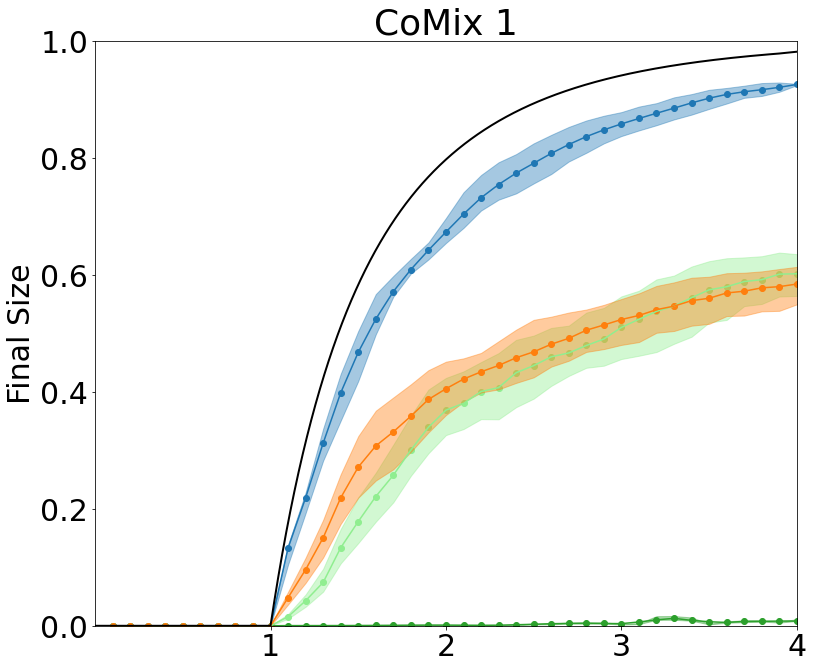

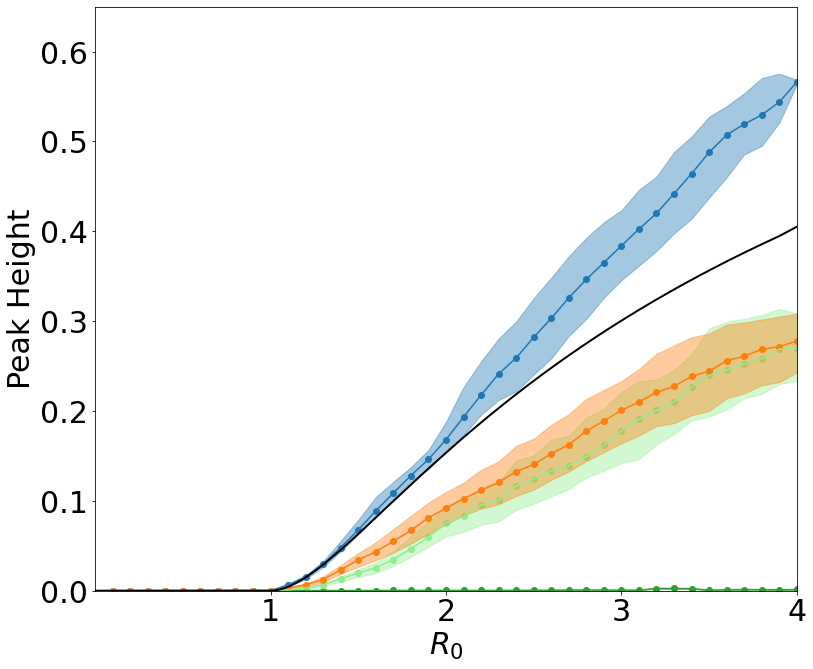

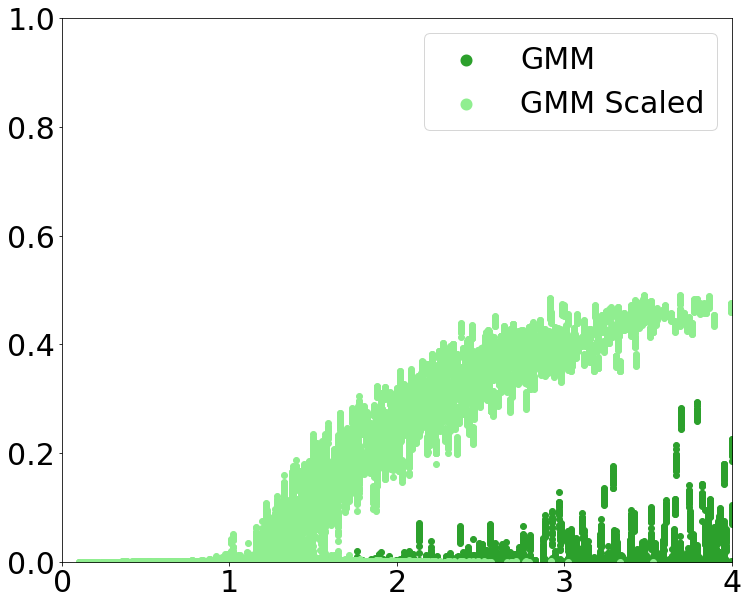

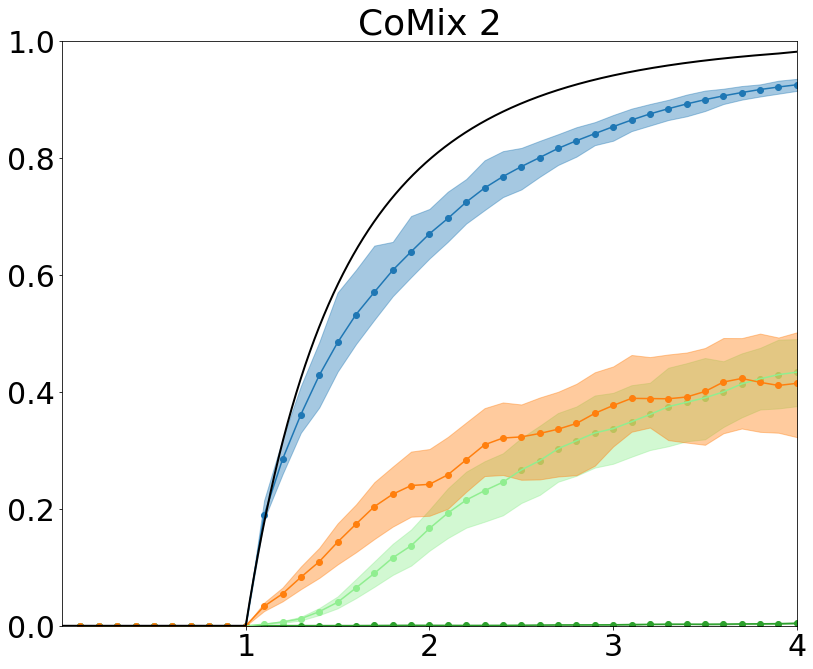

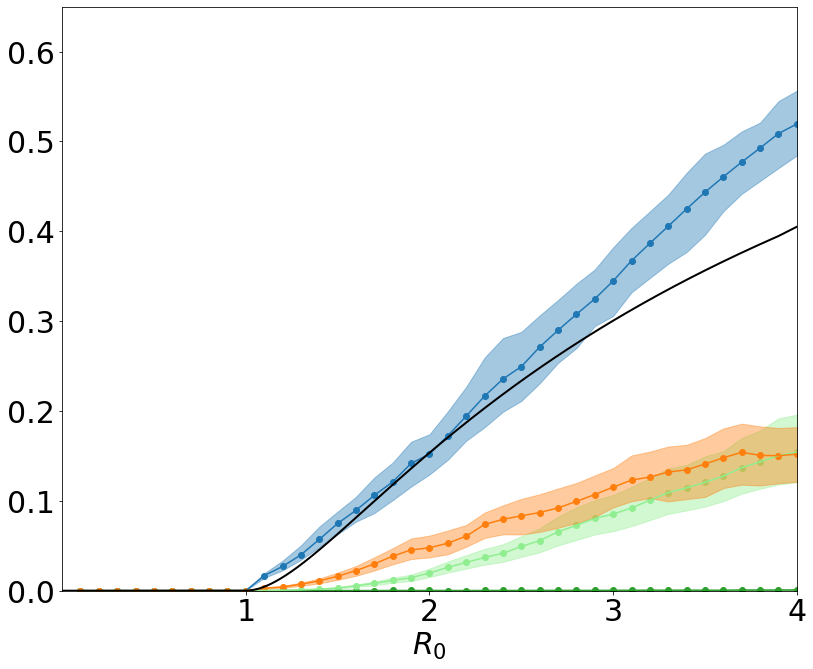

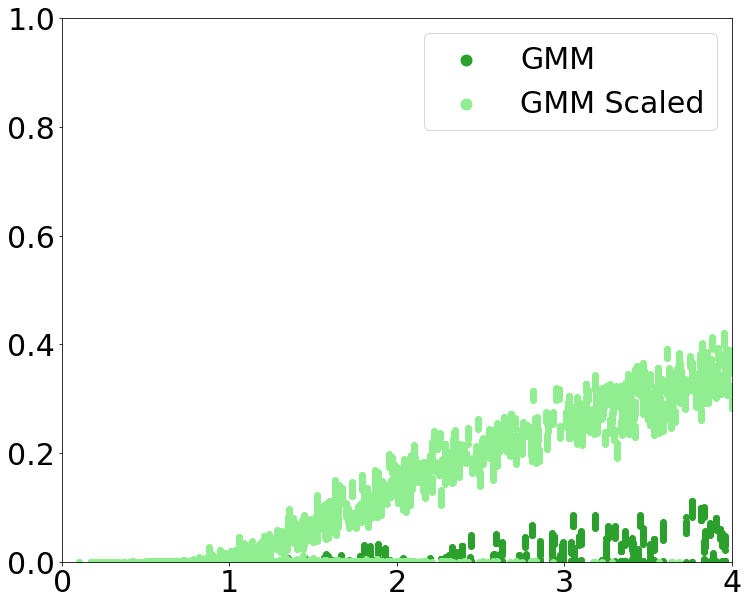

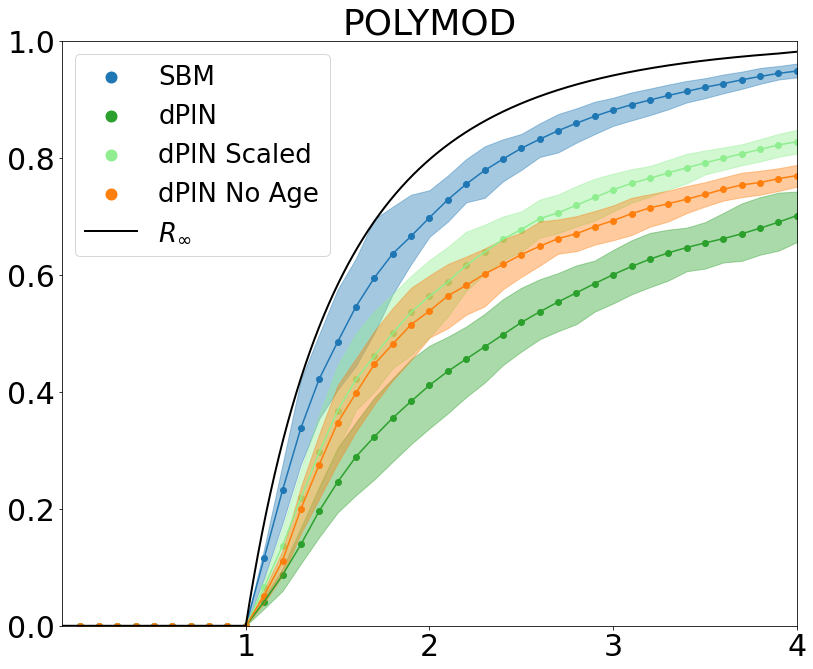

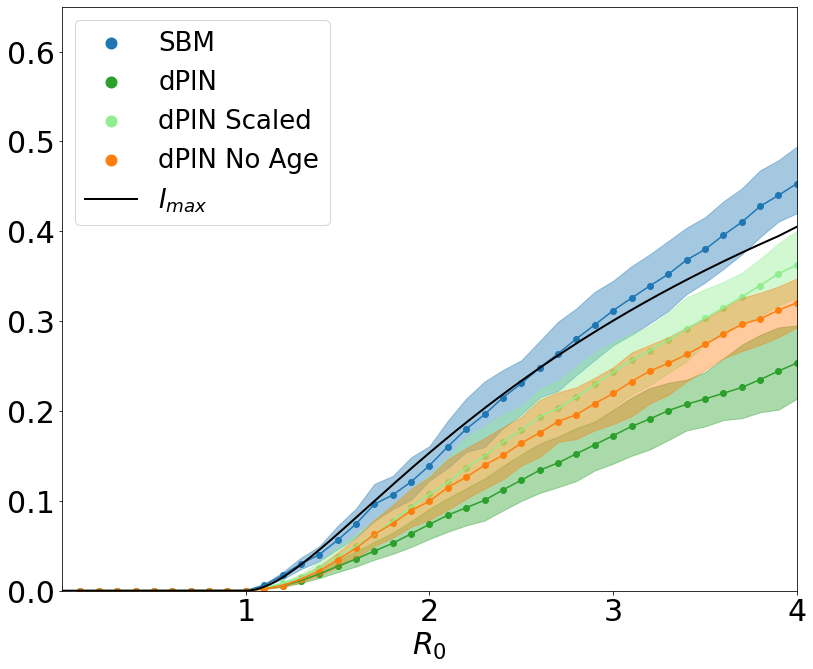

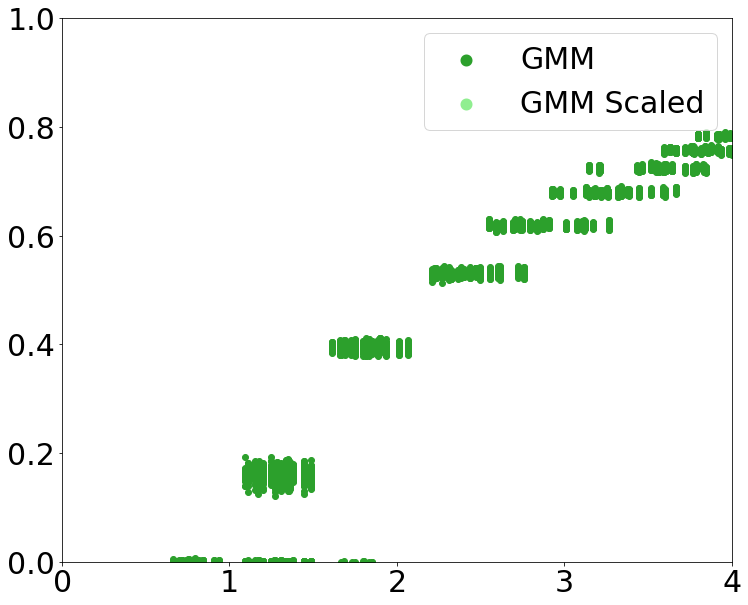

In [4]:
## maybe try scale this by the number of zeros in age vs no age... to change that no age goes below age structured 
plt.rcParams.update({'font.size': 30})


###################### Try do an R0 for each Tau #####################################

n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]

datas = ['comix1','comix2','poly']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
models = ['sbm','dpln']
model_names =['SBM', 'dPlN']
scales_n = ['none']
scales_s = ['fit1', 'fit2']

############################### no scale ################################
## 0
taus_n0 = [[np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.1,0.0025)]]
## 1,2,3,4
taus_n1 = [[np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.1,0.005)]]
# 5,6,7,8,9
taus_n2 = [[np.arange(0.1,0.205,0.005), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.05,0.2,0.01), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.001,0.1,0.005), np.arange(0.0025,0.05,0.0025)]]
# 10,11,12,13,14,15
taus_n3 = [[np.arange(0.1,0.305,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.05,0.25,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.001,0.1,0.002), np.arange(0.0001,0.04,0.0001)]]
# 17
taus_n4 = [[np.arange(0.28,0.38,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.2,0.32,0.005), np.arange(0.0001,0.002,0.0001)],
        [np.arange(0.001,0.08,0.001), np.arange(0.0001,0.03,0.0001)]]
# 18,19
taus_n5 = [[np.arange(0.005,0.1,0.005), np.arange(0.0005,0.005,0.0005)],
        [np.arange(0.005,0.1,0.005), np.arange(0.00005,0.001,0.00005)],
        [np.arange(0.001,0.05,0.001), np.arange(0.0001,0.03,0.0001)]]
# 20,21,22
taus_n6 = [[np.arange(0.005,0.05,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.005,0.05,0.005), np.arange(0.00005,0.001,0.00005)],
        [np.arange(0.001,0.025,0.001), np.arange(0.0005,0.015,0.0005)]]
# 23,24
taus_n7 = [[np.arange(0.1,0.205,0.005), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.05,0.2,0.01), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.001,0.1,0.005), np.arange(0.0025,0.05,0.0025)]]

taus_n = [taus_n0,taus_n1,taus_n2,taus_n3,taus_n4,taus_n5,taus_n6,taus_n7]

############################### scale ##################################
## 0
taus_s0 = [[np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.1,0.0025)]]
taus_s0 = [[10*x for x in a] for a in taus_s0]
## 1,2,3,4
taus_s1 = [[np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.1,0.005)]]
taus_s1 = [[10*x for x in a] for a in taus_s1]
## 5,6,7,8
taus_s2 = [[[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.05,0.002)]]
taus_s2 = [[10*x for x in a] for a in taus_s2]
# 10,11,12,13,14,15
taus_s3 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s3 = [[10*x for x in a] for a in taus_s3]
# 17
taus_s4 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s4 = [[15*x for x in a] for a in taus_s4]
# 18,19
taus_s5 = [[[],np.arange(0.005,0.3,0.005)],
        [[],np.arange(0.005,0.4,0.005)],
        [[],np.arange(0.005,0.2,0.005)]]
# 20,21,22
taus_s6 = [[[],np.arange(0.0025,0.1,0.0025)],
        [[],np.arange(0.0025,0.1,0.0025)],
        [[],np.arange(0.0025,0.1,0.0025)]]
# 23
taus_s7 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s7 = [[15*x for x in a] for a in taus_s7]

taus_s = [taus_s0,taus_s1,taus_s2,taus_s3,taus_s4,taus_s5,taus_s6,taus_s7]
############################### noage ################################
## 0,1
taus_na0 = [[[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.05,0.002)]]
taus_na0 = [[10*x for x in a] for a in taus_na0]
## 2,3
taus_na1 = [[[],np.arange(0.001,0.07,0.001)],
        [[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.05,0.002)]]
taus_na1 = [[20*x for x in a] for a in taus_na1]
## 4,5
taus_na2 = [[[],np.arange(0.005,0.4,0.005)],
        [[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.05,0.002)]]
## 6,7
taus_na3 = [[[],np.arange(0.4,0.605,0.005)],
        [[],np.arange(0.07,0.09,0.002)],
        [[],np.arange(0.05,0.09,0.002)]]
## 8,9,10,11,12
taus_na4 = [[[],np.arange(0.005,0.205,0.005)],
        [[],np.arange(0.001,0.02,0.002)],
        [[],np.arange(0.001,0.04,0.002)]]
## 13,14
taus_na5 = [[[],np.arange(0.4,0.805,0.005)],
        [[],np.arange(0.07,0.11,0.002)],
        [[],np.arange(0.05,0.11,0.002)]]
taus_na6 = [[[],np.arange(0.2,0.605,0.005)],
            [[],np.arange(0.09,0.4,0.005)],
            [[],np.arange(0.05,0.3,0.005)]]

taus_na = [taus_na0,taus_na1,taus_na2,taus_na3,taus_na4,taus_na5,taus_na6]

################################# gmm ###################################
## 0
taus_gn0 = [np.arange(0.0005,0.02,0.0005),
        np.arange(0.0005,0.02,0.0005),
        np.arange(0.0025,0.09,0.0025)]
## 1
taus_gn1 = [np.arange(0.001,0.03,0.001),
        np.arange(0.001,0.03,0.001),
        np.arange(0.005,0.11,0.005)]
taus_gn = [taus_gn0,taus_gn1]


## 0
taus_gs0 = [np.arange(0.0005,0.02,0.0005),
        np.arange(0.0005,0.15,0.0005),
        np.arange(0.0005,0.10,0.0005)]
taus_gs0 = [[15*x for x in a] for a in taus_gs0]
taus_gs = [taus_gs0]

#######################################################################

# bins 
top, step = 4.5, 0.10
bins = np.arange(step, top + step, step)
bin_centers = np.array([a/2 if i == 0 else a - (a - bins[i-1])/2 for i,a in enumerate(bins)])
digit = [a for a in bins]; digit.append(1e6)

#colours
# colours = {models[0]: 'tab:blue', models[1]: 'tab:green'}
# colours_scaled = {models[0]: 'lightblue', models[1]: 'red'}

# colours = {models[0]: "#0072B2", models[1]: "#D55E00"}
# colours_scaled = {models[0]: "#56B4E9", models[1]: "#E69F00"}
# colours_noage = {models[0]: "#CC79A7", models[1]: "#009E73"}
# colours_noage = {models[0]: "#CC79A7", models[1]: "#CC79A7"}

colours = {models[0]: "tab:blue", models[1]: "tab:green"}
colours_scaled = {models[0]: "#56B4E9", models[1]: "lightgreen"}
colours_noage = {models[0]: "#CC79A7", models[1]: "tab:orange"}

available_colors = [
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink',
    'brown', 'black', 'white', 'gray', 'cyan', 'magenta',
    'lime', 'teal', 'navy', 'maroon', 'olive', 'gold', 'silver'
]

n_gmm = 50_000
# ode solutions 
# R_inf
def R_inf(S, r0):
    return (r0*(1-S) + np.log(S))**2

def max_I(r0, S_0=1-10/n, I_0=10/n):
    return I_0 + S_0 + (1/r0)*(np.log(1/r0) - 1 - np.log(S_0))

r0s_ode = np.arange(0,3.9,0.001)

R = 1 - np.array([sc.optimize.fsolve(R_inf, x0=0.1, args=(r0), xtol=1e-10)[0] if r0 > 1 else 1 for r0 in r0s_ode])
peak_I = np.array([max_I(r0) if r0 > 1 else 0 for r0 in r0s_ode])

for i, data in enumerate(datas):
    fig1,ax1 = plt.subplots(1,1,figsize=(12,10))
    fig2,ax2 = plt.subplots(1,1,figsize=(12,10))
    fig3,ax3 = plt.subplots(1,1,figsize=(12,10))

    for j, model in enumerate(models):
        fs_n, ph_n = [[] for _ in bins], [[] for _ in bins]
        fs_s, ph_s = [[] for _ in bins], [[] for _ in bins]
        fs_na, ph_na = [[] for _ in bins], [[] for _ in bins]
        fs_gn, ph_gn = [[] for _ in bins], [[] for _ in bins]
        fs_gs, ph_gs = [[] for _ in bins], [[] for _ in bins]
        
        r0s_n, fs_n_try, ph_n_try = [], [], []
        r0s_s, fs_s_try, ph_s_try = [], [], []
        r0s_na, fs_na_try, ph_na_try = [], [], []
        r0s_gn, fs_gn_try, ph_gn_try = [], [], []
        r0s_gs, fs_gs_try, ph_gs_try = [], [], []
        
        for sim_num in range(40):
            
            #############      gmm     ####################
            if model == 'dpln':
                for network_num in range(20):
                    try:
                        with open(f'output_data/gmm/{sim_num}_{network_num}_{data}_gmm_none.json','r') as f:
                            tmp = json.load(f)
                        for tau, tau_sim in enumerate(tmp['r0_1']):
                        # for tau, tau_sim in enumerate(tmp['r0_23']):
                            
                            r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                            if r0 == -1: 
                                continue
                            final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                            peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                            bin_idx = np.digitize(r0, digit, right=False)
                            if bin_idx < len(bins):
                                fs_gn_try.append([])
                                for k, sims in enumerate(final_sizes):
                                    fs_gn[bin_idx].append(sims/n_gmm)
                                    ph_gn[bin_idx].append(peak_heights[k]/n_gmm)
                                    
                                    fs_gn_try[-1].append(sims/n_gmm)
                                    fs_n_try.append(peak_heights[k]/n_gmm)
                                r0s_gn.append(r0)
                    except: 
                        # print(f'No file {sim_num}_{data}_{model}_{scale}.json')
                        print('')
                    try:
                        with open(f'output_data/gmm/{sim_num}_{network_num}_{data}_gmm_scale.json','r') as f:
                            tmp = json.load(f)
                        for tau, tau_sim in enumerate(tmp['r0_1']):
                        # for tau, tau_sim in enumerate(tmp['r0_23']):
                            
                            r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                            if r0 == -1: 
                                continue
                            final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                            peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                            bin_idx = np.digitize(r0, digit, right=False)
                            if bin_idx < len(bins):
                                fs_gs_try.append([])
                                for k, sims in enumerate(final_sizes):
                                    fs_gs[bin_idx].append(sims/n_gmm)
                                    ph_gs[bin_idx].append(peak_heights[k]/n_gmm)
                                    
                                    fs_gs_try[-1].append(sims/n_gmm)
                                    fs_n_try.append(peak_heights[k]/n_gmm)
                                r0s_gs.append(r0)
                    except: 
                        # print(f'No file {sim_num}_{data}_{model}_{scale}.json')
                        print('')
                
            
            #######         no scale        ################
            
            for scale in scales_n:
                try:
                    with open(f'output_data/sims/{sim_num}_{data}_{model}_{scale}.json','r') as f:
                        tmp = json.load(f)
                    for tau, tau_sim in enumerate(tmp['r0_1']):
                    # for tau, tau_sim in enumerate(tmp['r0_23']):
                        
                        r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                        if r0 == -1: 
                            continue
                        final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                        peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                        bin_idx = np.digitize(r0, digit, right=False)
                        if bin_idx < len(bins):
                            fs_n_try.append([])
                            for k, sims in enumerate(final_sizes):
                                fs_n[bin_idx].append(sims/n)
                                ph_n[bin_idx].append(peak_heights[k]/n)
                                
                                fs_n_try[-1].append(sims/n)
                                # fs_n_try.append(peak_heights[k]/n)
                            r0s_n.append(r0)
                except: 
                    # print(f'No file {sim_num}_{data}_{model}_{scale}.json')
                    print('')
                
            ########          scaled           ############    
            # if means_z[i][1] > 0 and means_z[i][2] > 0:
            #     scale_zeros = 1 + (means_z[i][2] - means_z[i][1])/(means_z[i][2]) 
            # else:
            scale_zeros = 1          
            for scale in scales_s:
                try:
                    with open(f'output_data/sims/{sim_num}_{data}_{model}_{scale}.json','r') as f:
                        tmp = json.load(f)
                    for tau, tau_sim in enumerate(tmp['r0_1']):
                    # for tau, tau_sim in enumerate(tmp['r0_23']):
                        
                        r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                        if r0 == -1: 
                            continue
                        final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                        peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                        bin_idx = np.digitize(r0, digit, right=False)
                        if bin_idx < len(bins):
                            fs_s_try.append([])
                            for k, sims in enumerate(final_sizes):
                                fs_s[bin_idx].append(scale_zeros*sims/n)
                                ph_s[bin_idx].append(scale_zeros*peak_heights[k]/n)
                                
                                fs_s_try[-1].append(sims/n)
                                # fs_s_try.append(peak_heights[k]/n)
                            r0s_s.append(r0)
                except: 
                    # print(f'No file {sim_num}_{data}_{model}_{scale}.json')
                    print('')
                    
                
                
                if model == 'dpln':
                    try:
                        if data == 'comix2':
                            with open(f'output_data/sims/{sim_num}_{data}_{model}_{scale}_noage5.json','r') as f:
                                tmp = json.load(f)
                                print(tmp.keys())
                            for tau, tau_sim in enumerate(tmp['r0_1']):
                            # for tau, tau_sim in enumerate(tmp['r0_23']):
                                n_small = 30_000
                                r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                                if r0 == -1: 
                                    continue
                                final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                                peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                                bin_idx = np.digitize(r0, digit, right=False)
                                if bin_idx < len(bins):
                                    fs_na_try.append([])
                                    for k, sims in enumerate(final_sizes):
                                        fs_na[bin_idx].append(sims/n_small)
                                        ph_na[bin_idx].append(peak_heights[k]/n_small)
                                        
                                        fs_na_try[-1].append(sims/n_small)
                                        # fs_na_try.append(peak_heights[k]/n_small)
                                    r0s_na.append(r0)
                        else:
                            with open(f'output_data/sims/{sim_num}_{data}_{model}_{scale}_noage.json','r') as f:
                                tmp = json.load(f)
                            for tau, tau_sim in enumerate(tmp['r0_1']):
                            # for tau, tau_sim in enumerate(tmp['r0_23']):
                                
                                r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                                if r0 == -1: 
                                    continue
                                final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                                peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                                bin_idx = np.digitize(r0, digit, right=False)
                                if bin_idx < len(bins):
                                    fs_na_try.append([])
                                    for k, sims in enumerate(final_sizes):
                                        fs_na[bin_idx].append(sims/n)
                                        ph_na[bin_idx].append(peak_heights[k]/n)    
                                        
                                        fs_na_try[-1].append(sims/n)
                                        # fs_na_try.append(peak_heights[k]/n)
                                    r0s_na.append(r0)                
                                    
                    except:
                        # print(f'No file {sim_num}_{data}_{model}_{scale}_noage.json')
                        print('')
                        
        
        print(f'{data} {model} {sum([len(a) for a in fs_n])}')
        
        ###gmm 
        if model == 'dpln':
            print(r0s_gn,fs_gn)
            print('\n\n\n')
            print(r0s_gs,fs_gs)
            for index, vals in enumerate(fs_gn_try):
                if len(vals) > 0:
                    ax3.scatter([r0s_gn[index] for _ in vals], vals, color=colours[model])
            ax3.scatter([-1],[-1], label = f'GMM', linewidths=6, color=colours[model])
            for index, vals in enumerate(fs_gs_try):
                if len(vals) > 0:
                    ax3.scatter([r0s_gs[index] for _ in vals], vals, color=colours_scaled[model])
            ax3.scatter([-1],[-1], label = f'GMM Scaled', linewidths=6, color=colours_scaled[model])
            # ax3.scatter(r0s_gn, fs_gn, color=colours[model],label = f'GMM')
            # ax3.scatter(r0s_gs, fs_gs, color=colours_scaled[model],label = f'GMM Scaled')
            
            # mean, up, down = [np.mean(a) for a in fs_gn if len(a)>0], [np.percentile(a, 95) for a in fs_gn if len(a)>0], [np.percentile(a, 5) for a in fs_gn if len(a)>0]
            # # fs_n = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(fs_n) if len(a)>0]
            # index, tmp = 0, []
            # for a in fs_gn:
            #     if len(a) > 0:
            #         tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            #         index += 1
            # fs_gn = tmp
            # mean, up, down = [np.mean(a) for a in fs_gn if len(a)>0], [np.percentile(a, 95) for a in fs_gn if len(a)>0], [np.percentile(a, 5) for a in fs_gn if len(a)>0]
            # x = [bins[idx] for idx, a in enumerate(fs_gn) if len(a)>0]
            # # start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            
            # # mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
            # # mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
            # # mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
        
            # ax3.scatter(x, mean, color=colours[model])
            # ax3.plot(x, mean, color=colours[model])
            # ax3.fill_between(x, down,up, alpha = 0.4, color=colours[model])
            # ax3.scatter([-1],[-1], label = f'GMM', linewidths=6, color=colours[model])
        
            # mean, up, down = [np.mean(a) for a in fs_gs if len(a)>0], [np.percentile(a, 95) for a in fs_gs if len(a)>0], [np.percentile(a, 5) for a in fs_gs if len(a)>0]
            # if len(mean) > 0:
            #     # fs_s = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(fs_s) if len(a)>0]        index, tmp = 0, []
            #     index, tmp = 0, []
            #     for a in fs_s:
            #         if len(a) > 0:
            #             tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            #             index += 1
            #     fs_gs = tmp
            #     mean, up, down = [np.mean(a) for a in fs_gs if len(a)>0], [np.percentile(a, 95) for a in fs_gs if len(a)>0], [np.percentile(a, 5) for a in fs_gs if len(a)>0]
            #     x = [bins[idx] for idx, a in enumerate(fs_gs) if len(a)>0]
            #     # start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            #     # # start, end = 0, len(x)
            #     # ### smoothing and plot significant outbreaks with R0 1-4 
            #     # mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
            #     # mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
                
            #     ax3.scatter(x, mean, color=colours_scaled[model])
            #     ax3.plot(x, mean, color=colours_scaled[model])
            #     ax3.fill_between(x, down,up, alpha = 0.4, color=colours_scaled[model])
            #     ax3.scatter([-1],[-1], label = f'GMM Scaled', linewidths=6, color=colours_scaled[model])
        
        ## not gmm
        mean, up, down = [np.mean(a) for a in fs_n if len(a)>0], [np.percentile(a, 95) for a in fs_n if len(a)>0], [np.percentile(a, 5) for a in fs_n if len(a)>0]
        # fs_n = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(fs_n) if len(a)>0]
        index, tmp = 0, []
        for a in fs_n:
            if len(a) > 0:
                tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                index += 1
        fs_n = tmp
        mean, up, down = [np.mean(a) for a in fs_n if len(a)>0], [np.percentile(a, 95) for a in fs_n if len(a)>0], [np.percentile(a, 5) for a in fs_n if len(a)>0]
        x = [bins[idx] for idx, a in enumerate(fs_n) if len(a)>0]
        start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
        # start, end = 0, len(x)

        mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
        mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
        mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
    
        ax1.scatter(x, mean, color=colours[model])
        ax1.plot(x, mean, color=colours[model])
        ax1.fill_between(x, down,up, alpha = 0.4, color=colours[model])
        ax1.scatter([-1],[-1], label = f'{model_names[j]}', linewidths=6, color=colours[model])
        
        
        if model == 'dpln':
            mean, up, down = [np.mean(a) for a in fs_s if len(a)>0], [np.percentile(a, 95) for a in fs_s if len(a)>0], [np.percentile(a, 5) for a in fs_s if len(a)>0]
            # fs_s = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(fs_s) if len(a)>0]        index, tmp = 0, []
            index, tmp = 0, []
            for a in fs_s:
                if len(a) > 0:
                    tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                    index += 1
            fs_s = tmp
            mean, up, down = [np.mean(a) for a in fs_s if len(a)>0], [np.percentile(a, 95) for a in fs_s if len(a)>0], [np.percentile(a, 5) for a in fs_s if len(a)>0]
            x = [bins[idx] for idx, a in enumerate(fs_s) if len(a)>0]
            start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            # start, end = 0, len(x)
            ### smoothing and plot significant outbreaks with R0 1-4 
            mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
            mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
            
            ax1.scatter(x, mean, color=colours_scaled[model])
            ax1.plot(x, mean, color=colours_scaled[model])
            ax1.fill_between(x, down,up, alpha = 0.4, color=colours_scaled[model])
            ax1.scatter([-1],[-1], label = f'{model_names[j]} Scaled', linewidths=6, color=colours_scaled[model])
            
        if model == 'dpln':
            mean, up, down = [np.mean(a) for a in fs_na if len(a)>0], [np.percentile(a, 95) for a in fs_na if len(a)>0], [np.percentile(a, 5) for a in fs_na if len(a)>0]
            # fs_na = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(fs_na) if len(a)>0]
            index, tmp = 0, []
            for a in fs_na:
                if len(a) > 0:
                    tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                    index += 1
            fs_na = tmp
            mean, up, down = [np.mean(a) for a in fs_na if len(a)>0], [np.percentile(a, 95) for a in fs_na if len(a)>0], [np.percentile(a, 5) for a in fs_na if len(a)>0]
            x = [bins[idx] for idx, a in enumerate(fs_na) if len(a)>0]
            start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            # start, end = 0, len(x)
            ### smoothing and plot significant outbreaks with R0 1-4 
            mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
            mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
            
            ax1.scatter(x, mean, color=colours_noage[model])
            ax1.plot(x, mean, color=colours_noage[model])
            ax1.fill_between(x, down,up, alpha = 0.4, color=colours_noage[model])
            ax1.scatter([-1],[-1], label = f'{model_names[j]} No Age', linewidths=6, color=colours_noage[model])
            
        mean, up, down = [np.mean(a) for a in ph_n if len(a)>0], [np.percentile(a, 95) for a in ph_n if len(a)>0], [np.percentile(a, 5) for a in ph_n if len(a)>0]
        # ph_n = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(ph_n) if len(a)>0]
        index, tmp = 0, []
        for a in ph_n:
            if len(a) > 0:
                tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                index += 1
        ph_n = tmp
        mean, up, down = [np.mean(a) for a in ph_n if len(a)>0], [np.percentile(a, 95) for a in ph_n if len(a)>0], [np.percentile(a, 5) for a in ph_n if len(a)>0]
        x = [bins[idx] for idx, a in enumerate(ph_n) if len(a)>0]
        start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
        # start, end = 0, len(x)
        ### smoothing and plot significant outbreaks with R0 1-4 
        mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
        mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
        
        ax2.scatter(x, mean, color=colours[model])
        ax2.plot(x, mean, color=colours[model])
        ax2.fill_between(x, down,up, alpha = 0.4, color=colours[model])
        ax2.scatter([-1],[-1], label = f'{model_names[j]}', linewidths=6, color=colours[model])
        
        if model == 'dpln':
            mean, up, down = [np.mean(a) for a in ph_s if len(a)>0], [np.percentile(a, 95) for a in ph_s if len(a)>0], [np.percentile(a, 5) for a in ph_s if len(a)>0]
            # ph_n = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(ph_n) if len(a)>0]
            index, tmp = 0, []
            for a in ph_s:
                if len(a) > 0:
                    tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                    index += 1
            ph_s = tmp
            mean, up, down = [np.mean(a) for a in ph_s if len(a)>0], [np.percentile(a, 95) for a in ph_s if len(a)>0], [np.percentile(a, 5) for a in ph_s if len(a)>0]
            x = [bins[idx] for idx, a in enumerate(ph_s) if len(a)>0]
            start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            # start, end = 0, len(x)
            ### smoothing and plot significant outbreaks with R0 1-4 
            mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
            mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
            
            ax2.scatter(x, mean, color=colours_scaled[model])
            ax2.plot(x, mean, color=colours_scaled[model])
            ax2.fill_between(x, down,up, alpha = 0.4, color=colours_scaled[model])
            ax2.scatter([-1],[-1], label = f'{model_names[j]} Scaled', linewidths=6, color=colours_scaled[model])
        
        if model == 'dpln':
            mean, up, down = [np.mean(a) for a in ph_na if len(a)>0], [np.percentile(a, 95) for a in ph_na if len(a)>0], [np.percentile(a, 5) for a in ph_na if len(a)>0]
            # ph_na = [[b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33] for index, a in enumerate(ph_na) if len(a)>0]
            index, tmp = 0, []
            for a in ph_na:
                if len(a) > 0:
                    tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                    index += 1
            ph_na = tmp
            mean, up, down = [np.mean(a) for a in ph_na if len(a)>0], [np.percentile(a, 95) for a in ph_na if len(a)>0], [np.percentile(a, 5) for a in ph_na if len(a)>0]
            x = [bins[idx] for idx, a in enumerate(ph_na) if len(a)>0]
            start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
            # start, end = 0, len(x)
            ### smoothing and plot significant outbreaks with R0 1-4 
            mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if idx in [start,end-1] else a  if idx<start else (up[idx-1]+a+up[idx+1])/3 for idx, a in enumerate(up)]        
            mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]
            
            ax2.scatter(x, mean, color=colours_noage[model])
            ax2.plot(x, mean, color=colours_noage[model])
            ax2.fill_between(x, down,up, alpha = 0.4, color=colours_noage[model])
            ax2.scatter([-1],[-1], label = f'{model_names[j]} No Age', linewidths=6, color=colours_noage[model])
    
    r0s_ode = list(r0s_ode); R = list(R); peak_I = list(peak_I) 
    r0s_ode.append(4)
    peak_I.append(0.405)
    R.append(0.981)

    ax1.plot(r0s_ode,R,'k',label = r'$R_\infty$', linewidth=2)
    ax1.set_title(f'{data_names[i]}')
    ax1.set_ylabel('Final Size')
    ax1.set_xlim([0,4])
    ax1.set_ylim([0,1])
    if i == 2:
        ax1.legend(prop={'size': 26})
    if i != 0:
        ax1.set_ylabel('')
    ax1.set_xticks([1,2,3,4])
    
    fig1.tight_layout()
    # fig1.savefig(f'fs_{data}_dots.pdf')
    # fig1.show()
    
    ax2.plot(r0s_ode, peak_I,'k',label = r'$I_{max}$', linewidth=2)
    ax2.set_title(f'')
    ax2.set_ylabel('Peak Height')
    ax2.set_xlim([0,4])
    ax2.set_ylim([0,0.65])
    if i == 2:
        ax2.legend(prop={'size':26})
    if i != 0:
        ax2.set_ylabel('')
    ax2.set_xlabel(r'$R_0$')
    ax2.set_xticks([1,2,3,4])
    
    fig2.tight_layout()
    # fig2.savefig(f'ph_{data}_dots.pdf')
    # fig2.show() 
    
    ax3.set_xlim([0,4])
    ax3.set_ylim([0,1])
    ax3.legend()

## Secondary Case Distributions

### Helper Functions

In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import nbinom
def log_bins(x, num_bins=5):
    """
    Returns log bins of contacts, A^m
    Input: Contacts -> np array, num_bins -> int
    Output: Geometric center of bins -> ndarray, values in bins -> ndarray
    """
    count_zeros = np.sum([1 if a == 0 else 0 for a in x])
    x = np.sort([a for a in x if a > 0])
    max1, min1 = np.log(np.ceil(max(x))), np.log(np.floor(min(x)))
    x = np.log(x)
    t, freq, ends = np.zeros(num_bins), np.zeros(num_bins), np.zeros((2,num_bins))
    step = (max1 - min1)/num_bins
    for val in x:
        for k in range(num_bins):
            if k*step + min1 <= val and val < (k+1)*step + min1:
                freq[k] += 1
            t[k] = (k+1)*step - (.5*step) + min1
            ends[0,k] = k*step + min1
            ends[1,k] = (k+1)*step + min1
    freq[0] += count_zeros
    ends = np.exp(ends)
    widths = ends[1] - ends[0]
    freq = freq/widths/(len(x)+count_zeros)
    # freq = 1/np.sqrt(freq)*freq
    midpoints = np.exp(t)
    return midpoints, freq

def log_bins_from_a(x, min_val=5, num_bins=5):
    """
    Returns log bins of contacts, A^m
    Input: Contacts -> np array, num_bins -> int
    Output: Geometric center of bins -> ndarray, values in bins -> ndarray
    """
    start = len(x)
    # count_zeros = np.sum(x[x==0])
    count_zeros = sum([1 if a==0 else 0 for a in x])
    x_under_a = np.sort([a for a in x if a <= min_val])
    x = np.sort([a for a in x if a > 0])
    count_under_a = sum([1 if a<=min_val else 0 for a in x])
    x = np.sort([a for a in x if a > min_val])
    # print(f'all = {start}, {len(x) + count_zeros + count_under_a}')
    max1, min1 = np.log(np.ceil(max(x))), np.log(np.floor(min(x)))
    x = np.log(x)
    t, freq, ends = np.zeros(num_bins), np.zeros(num_bins), np.zeros((2,num_bins))
    step = (max1 - min1)/num_bins
    for val in x:
        for k in range(num_bins):
            if k*step + min1 <= val and val < (k+1)*step + min1:
                freq[k] += 1
            t[k] = (k+1)*step - (.5*step) + min1
            ends[0,k] = k*step + min1
            ends[1,k] = (k+1)*step + min1
    # freq[0] += count_zeros
    ends = np.exp(ends)
    widths = ends[1] - ends[0]
    freq = freq/widths/(len(x)+count_zeros + count_under_a)
    # freq = 1/np.sqrt(freq)*freq
    midpoints = np.exp(t)
    
    midpoints_ua = np.arange(min_val+1)
    freq_ua = np.zeros(min_val+1)
    for val in x_under_a:
        freq_ua[val] += 1
    freq = np.concatenate((freq_ua/(len(x)+count_zeros+count_under_a), freq))
    midpoints = np.concatenate((midpoints_ua, midpoints))
    return midpoints, freq

def log_likelihood_nbinom(params, contacts):
    r, p = params
    log_likelihood = nbinom.logpmf(contacts, r, p)
    return -np.sum(log_likelihood)

def log_likelihood_nbinom_mean(params, contacts,r0):
    r = params
    p = r/(r+r0)
    log_likelihood = nbinom.logpmf(contacts, r, p)
    return -np.sum(log_likelihood)

### Make figs

#### dpln


sbm k = 0.8732219268853182

80% of cases caused by 0.3986408017549142% of people

dpln k = 0.042607368094944045

80% of cases caused by 0.05504587155963303% of people


scale k = 0.468286995002449

80% of cases caused by 0.2878584132217065% of people


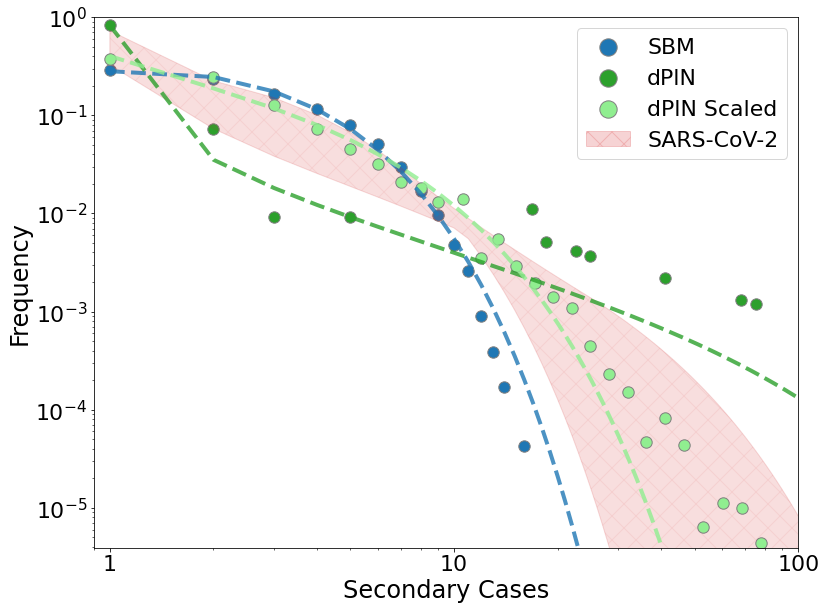


sbm k = 0.7936129637633078

80% of cases caused by 0.3836989247311828% of people

dpln k = 0.07317132973912331

80% of cases caused by 0.06911385144823631% of people


scale k = 0.36261041360025537

80% of cases caused by 0.24085689045936395% of people


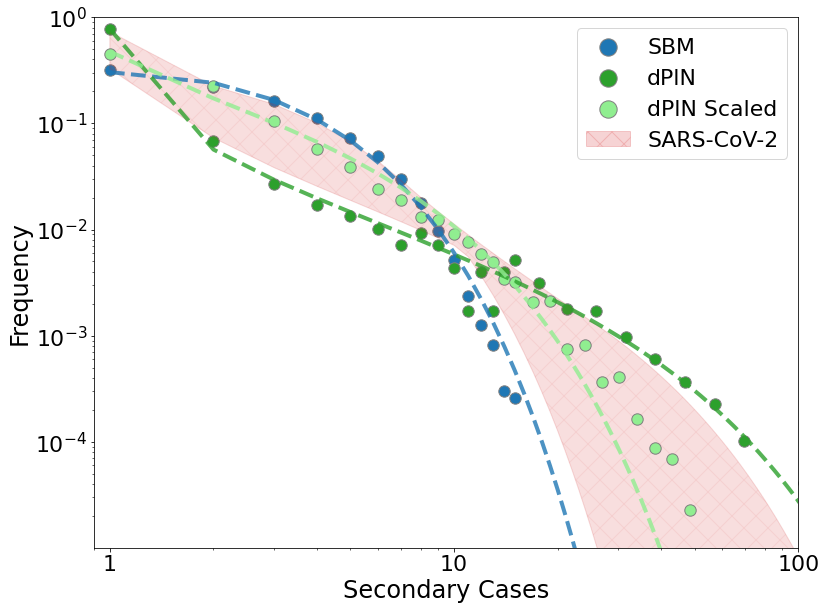


sbm k = 0.7403219948938176

80% of cases caused by 0.37267294380669846% of people

dpln k = 0.46485908982168256

80% of cases caused by 0.28996074032529445% of people


scale k = 0.6494673607328608

80% of cases caused by 0.3503611747912972% of people


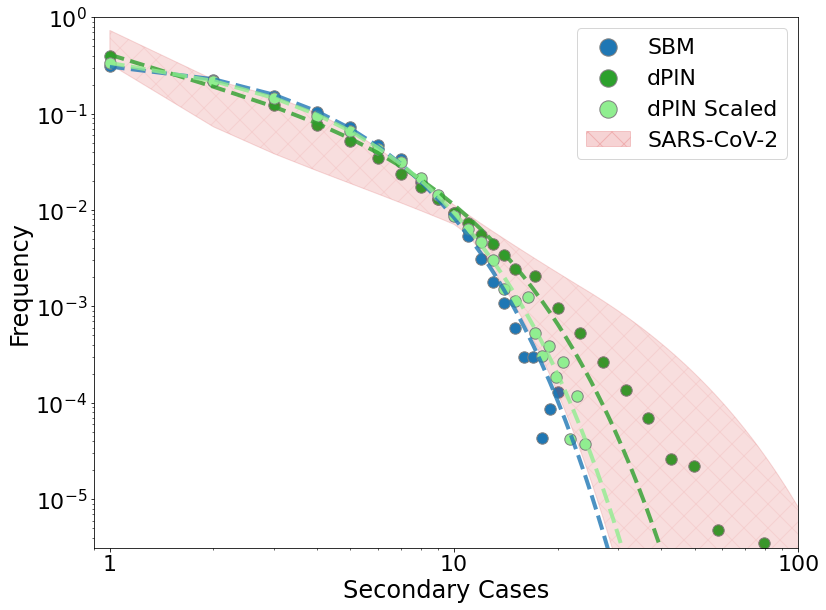

In [29]:
from scipy.stats import nbinom
from scipy.optimize import minimize
#### do this ########
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
plt.rcParams.update({'font.size': 24})

datas = ['comix1','comix2','poly']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
models = ['sbm','dpln','scale']
model_names =['SBM', 'dPlN', 'Scaled']
scales_n = ['none']
scales_s = ['fit1', 'fit2']
R0s = [2,2.5,3]

for i, data in enumerate(datas):
    for R0_idx in range(3):
        if R0_idx != 0: 
            continue
        # fig1,ax1 = plt.subplots(1,1,figsize=(12,10))
        # fig2,ax2 = plt.subplots(1,1,figsize=(12,10))
        fig3,ax3 = plt.subplots(1,1,figsize=(12,9))
        
        max_x, max_y = 0,0
        min_x, min_y = 1,1
        for j, model in enumerate(models):
            r01, sc1 = [], []
            for sim_num in range(12):
                try:
                    if j == 2:
                        with open(f'output_data/sims/{sim_num}_{data}_{models[1]}_fit1_sc.json','r') as f:
                            sc_main = json.load(f)
                    else:
                        with open(f'output_data/sims/{sim_num}_{data}_{model}_none_sc.json','r') as f:
                            sc_main = json.load(f)
                    for val in sc_main['r0_1'][R0_idx]:
                        r01.append(val)
                    if sim_num > 4:
                        for val in sc_main['secondary_cases1'][R0_idx]:
                            sc1.append(val)
                    else:
                        for val in sc_main['secondary_cases'][R0_idx]:
                            sc1.append(val)
                except:
                    print(f'')
            if len(sc1) == 0:
                print(f'no data {data} {model}')
                continue
            if i == 0:
                min_val, num_bins = 8,17
            else:
                min_val, num_bins = 14,11
            # min_val, num_bins = 5,5
            
            if j == 0:
                colour = 'tab:blue'
            elif j == 2:
                colour = 'lightgreen'
            else:
                colour = 'tab:green'
            
            if j >= 1:    
                # print(f'here {len(sc1)}')
                xs,ys = log_bins_from_a(sc1, min_val=min_val, num_bins=num_bins)
                xs, ys = np.array([x+1 for i, x in enumerate(xs) if ys[i] > 0]), np.array([y for y in ys if y > 0])
                if max_x < max(xs):
                    max_x = max(xs)
                if min_x > min(xs):
                    min_x = min(xs)
                if max_y < max([a for a in ys if a > 0]):
                    max_y = max([a for a in ys if a > 0])
                if min_y > min([a for a in ys if a > 0]):
                    min_y = min([a for a in ys if a > 0])
            # non binned
            y,x = np.histogram(sc1, bins=np.arange(max(sc1) + 1), density=True)
            
            # change legend , fit to nb , add labels
            result = minimize(log_likelihood_nbinom, x0=[1, 0.5], args=(sc1), method='Nelder-Mead')
            x_fit = np.arange(0, max(sc1)+200)
            # print(result.x)
            # if j ==1 or j==0:
            #     print(f'no scale')
            # else:
            #     print(f'scale')
            # if j!=0:
            print(f'{model} k = {result.x[0]*(1-result.x[1])}\n')
            # print(f'here: ')

            tmp_sort = sorted(sc1,reverse=True)
            total = sum(sc1)
            cumsum, count = 0, 0
            for value in tmp_sort:
                cumsum += value
                count += 1
                # Stop once we reach 80% of the total sum
                if cumsum >= 0.8 * total:
                    break
    
            print(f'80% of cases caused by {count/len(tmp_sort)}% of people')
            
            pmf_nbinom = nbinom.pmf(x_fit, result.x[0], result.x[1])
            
             
            x_pois = np.arange(0,max(x))
            # pmf_pois = sc_main.stats.poisson.pmf(x_pois, 3)
            k_cov = 0.4
            p = k_cov/R0s[R0_idx]
            # dfTeX error: pdflatex (file ./figs/contact matrices/cmfinal_CoMix 1_sbm.pdf): xpdf: reading PDF image failedp = k_cov/R0s[R0_idx]
            pmf_cov = nbinom.pmf(x_fit, k_cov/(1-p), p)
            # if j == 1:
            #     # ax1.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            #     # p5,=ax1.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            #     ax3.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            #     p52,=ax3.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            # if j == 2:
                # ax2.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
                # p51,=ax2.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
                # ax3.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
                # p52,=ax3.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            
            pmfs = []
            for k_cov in np.arange(0.1,0.7,0.01):
                p = k_cov/R0s[R0_idx]
                pmfs.append(nbinom.pmf(x_fit, k_cov/(1-p), p))
                # p5,=ax1.plot(x_fit+1, pmfs[-1], 'tab:red', linewidth=0.1)
            upper,lower= [],[]
            for index in range(len(pmfs[0])):
                upper.append(max([a[index] for a in pmfs]))
                lower.append(min([a[index] for a in pmfs]))
            if j == 1:
                # ax1.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
                ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red')
            if j == 2:
                ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
                # ax3.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
                # ax2.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
                
            if j == 0:
                # ax1.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                # p3,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
                # ax2.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                # p31,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
                ax3.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="SBM")
                p32,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                # poisson example 
            else:
                if j == 1:
                    # ax1.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    # p4,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="dPlN", c=colour)
                    ax3.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN")
                    p42,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                    
                if j == 2:
                    # ax2.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    # p41,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="dPlN Scaled", c=colour)
                    ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN Scaled")
                    ax3.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    p42,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
               
            if j == 2:
                # ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
                ax3.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
            
        ax3.set_yscale('log')    
        ax3.set_xscale('log')    
        ax3.set_xlabel('Secondary Cases')
        ax3.set_ylabel('Frequency')

        ax3.set_ylim([min_y*.9, 1])
        # ax3.set_xlim([0.9,max_x*1.1])
        ax3.set_xlim([0.9,100])
        # ax3.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-])
        ax3.set_xticks([1,10,100],[1,10,100])
        
        # ax3.set_title(f'{data}: $R_0$ {R0s[R0_idx]}')
        ax3.legend(prop={'size':22})
        ax3.tick_params(axis='both', which='major', labelsize=22)
        ax3.tick_params(axis='both', which='minor', labelsize=22)
        fig3.tight_layout()
        plt.show()
        # fig3.savefig(f'../output_data/secondary_cases/scfinal_{data}_{model}_{R0s[R0_idx]}.pdf')

#### GMM

In [8]:
with open(f'output_data/gmm/0_8_poly_gmm_scale_sc.json','r') as f:
    res = json.load(f)
print(len(res['r0_1'][0]), len([a for a in res['r0_1'][0] if a > 0]), len(res['secondary_cases'][0]))

48 19 190


no comix1 gmm 25
no comix1 gmm 26
no comix1 gmm 27
no comix1 gmm 28
no comix1 gmm 29
no comix1 gmm 30
no comix1 gmm 31
no comix1 gmm 32
no comix1 gmm 33
no comix1 gmm 34
no comix1 gmm 35
no comix1 gmm 36
no comix1 gmm 37
no comix1 gmm 38
no comix1 gmm 39
no comix1 gmm 40
no comix1 gmm 41
no comix1 gmm 42
no comix1 gmm 43
no comix1 gmm 44
no comix2 gmm 25
no comix2 gmm 26
no comix2 gmm 27
no comix2 gmm 28
no comix2 gmm 29
no comix2 gmm 30
no comix2 gmm 31
no comix2 gmm 32
no comix2 gmm 33
no comix2 gmm 34
no comix2 gmm 35
no comix2 gmm 36
no comix2 gmm 37
no comix2 gmm 38
no comix2 gmm 39
no comix2 gmm 40
no comix2 gmm 41
no comix2 gmm 42
no comix2 gmm 43
no comix2 gmm 44
no poly gmm 25
no poly gmm 26
no poly gmm 27
no poly gmm 28
no poly gmm 29
no poly gmm 30
no poly gmm 31
no poly gmm 32
no poly gmm 33
no poly gmm 34
no poly gmm 35
no poly gmm 36
no poly gmm 37
no poly gmm 38
no poly gmm 39
no poly gmm 40
no poly gmm 41
no poly gmm 42
no poly gmm 43
no poly gmm 44


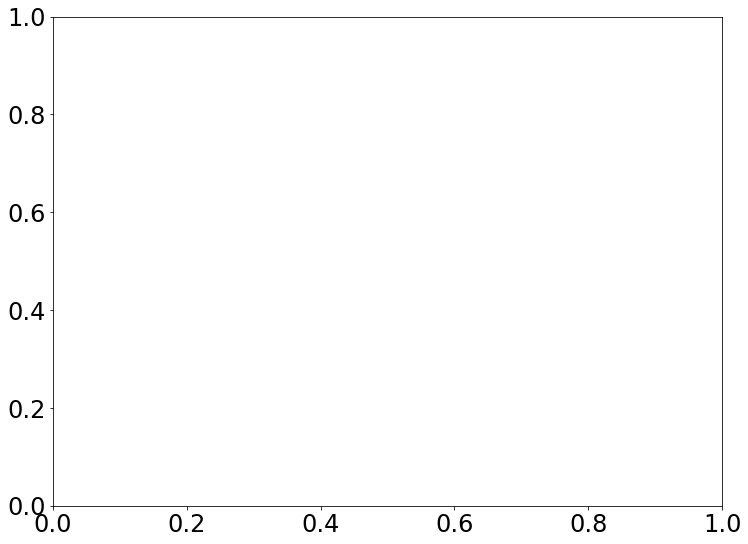

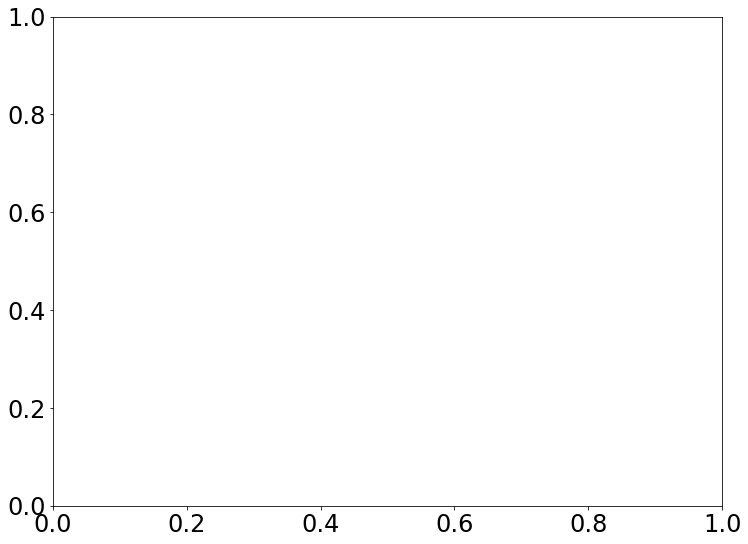

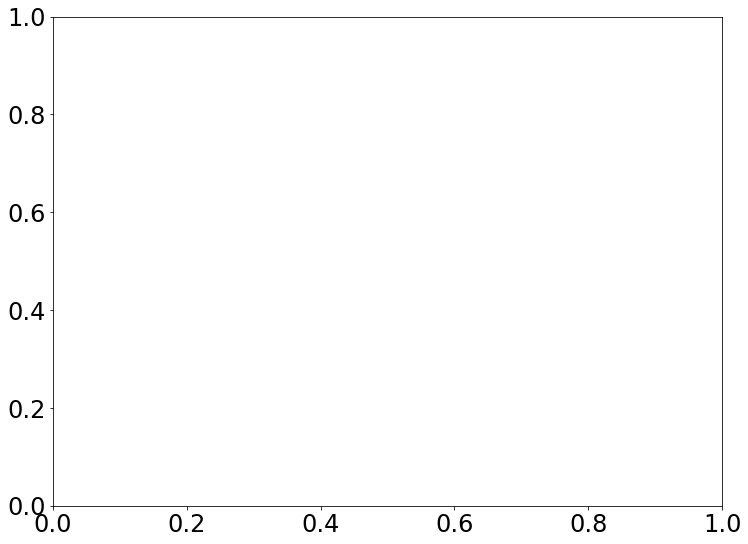

In [6]:
from scipy.stats import nbinom
from scipy.optimize import minimize
#### do this ########
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
plt.rcParams.update({'font.size': 24})

datas = ['comix1','comix2','poly']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
models = ['sbm','gmm','gmm_scale']
model_names =['SBM', 'GMM', 'GMM Scaled']
scales_n = ['none']
scales_s = ['scale']
# R0s = [2,2.5,3]

for i, data in enumerate(datas):
    fig,ax = plt.subplots(1,1,figsize=(12,9))
    for j, model in enumerate(models[1:2]):
        r0, sc = [], []
        for network_num in range(65):
            try:
                with open(f'output_data/gmm/0_{network_num}_{data}_{model}_sc.json','r') as f:
                    res = json.load(f)
                for index, x in res['r0_1']:
                    if x >= 0:
                        r0.append(x)
                        sc.append(res['secondary_cases'][index])
            except:
                x=1
        print(f'{data} {model} {np.mean(r0)} {np.mean(sc)}')
    
    # max_x, max_y = 0,0
    # min_x, min_y = 1,1
    # for j, model in enumerate(models):
    #     r01, sc1 = [], []
    #     for sim_num in range(12):
    #         try:
    #             if j == 2:
    #                 with open(f'output_data/sims/{sim_num}_{data}_{models[1]}_fit1_sc.json','r') as f:
    #                     sc_main = json.load(f)
    #             else:
    #                 with open(f'output_data/sims/{sim_num}_{data}_{model}_none_sc.json','r') as f:
    #                     sc_main = json.load(f)
    #             for val in sc_main['r0_1'][R0_idx]:
    #                 r01.append(val)
    #             if sim_num > 4:
    #                 for val in sc_main['secondary_cases1'][R0_idx]:
    #                     sc1.append(val)
    #             else:
    #                 for val in sc_main['secondary_cases'][R0_idx]:
    #                     sc1.append(val)
    #         except:
    #             print(f'')
    #     if len(sc1) == 0:
    #         print(f'no data {data} {model}')
    #         continue
    #     if i == 0:
    #         min_val, num_bins = 8,17
    #     else:
    #         min_val, num_bins = 14,11
    #     # min_val, num_bins = 5,5
        
    #     if j == 0:
    #         colour = 'tab:blue'
    #     elif j == 2:
    #         colour = 'lightgreen'
    #     else:
    #         colour = 'tab:green'
        
    #     if j >= 1:   
    #         xs,ys = log_bins_from_a(sc1, min_val=min_val, num_bins=num_bins)
    #         xs, ys = np.array([x+1 for i, x in enumerate(xs) if ys[i] > 0]), np.array([y for y in ys if y > 0])
    #         if max_x < max(xs):
    #             max_x = max(xs)
    #         if min_x > min(xs):
    #             min_x = min(xs)
    #         if max_y < max([a for a in ys if a > 0]):
    #             max_y = max([a for a in ys if a > 0])
    #         if min_y > min([a for a in ys if a > 0]):
    #             min_y = min([a for a in ys if a > 0])
    #     # non binned
    #     y,x = np.histogram(sc1, bins=np.arange(max(sc1) + 1), density=True)
        
    #     # change legend , fit to nb , add labels
    #     result = minimize(log_likelihood_nbinom, x0=[1, 0.5], args=(sc1), method='Nelder-Mead')
    #     x_fit = np.arange(0, max(sc1)+200)

    #     print(f'{model} k = {result.x[0]*(1-result.x[1])}\n')

    #     tmp_sort = sorted(sc1,reverse=True)
    #     total = sum(sc1)
    #     cumsum, count = 0, 0
    #     for value in tmp_sort:
    #         cumsum += value
    #         count += 1
    #         # Stop once we reach 80% of the total sum
    #         if cumsum >= 0.8 * total:
    #             break

    #     print(f'80% of cases caused by {count/len(tmp_sort)}% of people')
        
    #     pmf_nbinom = nbinom.pmf(x_fit, result.x[0], result.x[1])
        
    #     x_pois = np.arange(0,max(x))
    #     k_cov = 0.4
    #     p = k_cov/R0s[R0_idx]
    #     pmf_cov = nbinom.pmf(x_fit, k_cov/(1-p), p)
    #     pmfs = []
    #     for k_cov in np.arange(0.1,0.7,0.01):
    #         p = k_cov/R0s[R0_idx]
    #         pmfs.append(nbinom.pmf(x_fit, k_cov/(1-p), p))
    #     upper,lower= [],[]
    #     for index in range(len(pmfs[0])):
    #         upper.append(max([a[index] for a in pmfs]))
    #         lower.append(min([a[index] for a in pmfs]))
    #     if j == 1:
    #         ax.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red')
    #     if j == 2:
    #         ax.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
            
    #     if j == 0:
    #         ax.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
    #         ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="SBM")
    #         p32,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
    #     else:
    #         if j == 1:
    #             ax.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
    #             ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN")
    #             p42,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                
    #         if j == 2:
    #             ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN Scaled")
    #             ax.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
    #             p42,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
            
    #     if j == 2:
    #         ax.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
        
    # ax.set_yscale('log')    
    # ax.set_xscale('log')    
    # ax.set_xlabel('Secondary Cases')
    # ax.set_ylabel('Frequency')

    # ax.set_ylim([min_y*.9, 1])
    # ax.set_xlim([0.9,100])
    # ax.set_xticks([1,10,100],[1,10,100])
    
    # ax.legend(prop={'size':22})
    # ax.tick_params(axis='both', which='major', labelsize=22)
    # ax.tick_params(axis='both', which='minor', labelsize=22)
    # fig.tight_layout()
    # plt.show()

## Explanatory figs

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sklearn.mixture
import math
import json
import scipy.signal

22121 2310
(-16.277438836608713, -1.2467998302351073)
22121 19811
(-13.204669058585822, -2.6956541183323326)


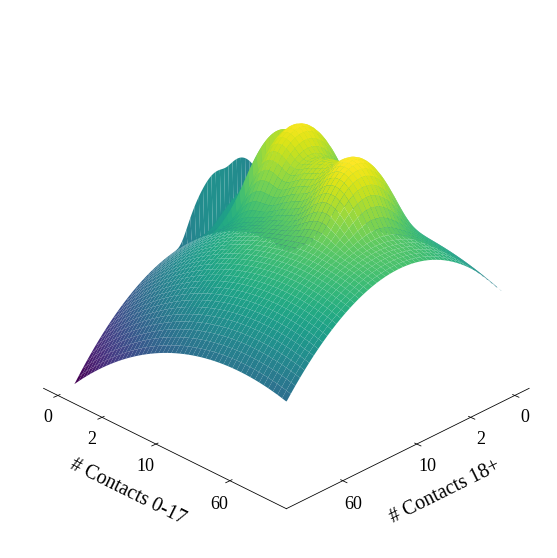

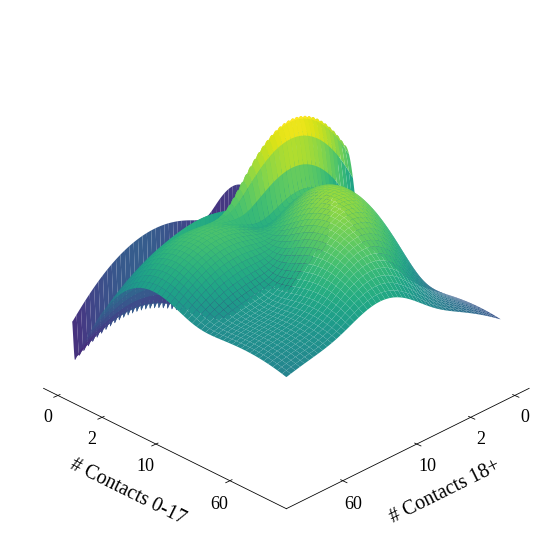

In [19]:
# defining surface and axes
# partition the data of under 18 and over 18
import scipy.ndimage
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 20})

n=2000
max_x = 5
datas = ['comix2']
for i, data in enumerate(datas):
    with open(f'input_data/gmm/optimal_components_{data}_log.json', 'r') as f:
        optimal_num_components = json.load(f)
    ##################### read fits ####################################
    with open(f'input_data/egos/{data}.json', 'r') as f:
        egos_pre = json.load(f)
    # reduce egos to 2 dimensions 
    egos = [{'age': 0 if ego['age'] < 2 else 1, 'contacts': [sum(ego['contacts'][:3]), sum(ego['contacts'][3:])], 'degree': ego['degree']} for ego in egos_pre]
    classifier = []
    samples = []
    for l in [0,1]:
        classifier.append(sklearn.mixture.GaussianMixture(n_components=10, covariance_type='full'))
        egos_age = [a for a in egos if a['age'] == l]
        print(len(egos_pre), len(egos_age))
        ## use log(k+1) instead of k to fit
        X = [[math.log(b+1) for b in a['contacts']] for a in egos_age]
        classifier[l].fit(X)
    
        x=np.outer(np.linspace(0,max_x,n), np.ones(n)) 
        y=x.copy().T
        z=np.zeros((len(x), len(x[0])))
        for i in range(len(z)):
            tmp = classifier[l].score_samples([[x[i,j], y[i,j]] for j in range(len(x[i]))])
            # print(tmp)
            for j, val in enumerate(tmp):
                z[i,j] = val
        # for i in range(len(x)):
        #     for j in range(len(x[0])):
        #         z[i,j] = classifier[l].predict_proba(np.array(x[i][j],y[i][j]))
    
        # x = np.outer(np.linspace(-2, 2, 10), np.ones(10))
        # y = x.copy().T
        # z = np.cos(x ** 2 + y ** 3)
        # print(z)

        fig = plt.figure(figsize=(12,10))

        # syntax for 3-D plotting
        # ax = plt.axes(projection='3d')
        ax = fig.add_subplot(projection='3d')

        #smoothing
        # z = scipy.signal.savgol_filter(z, window_length=15, polyorder=3, axis=0)
        # z = scipy.ndimage.median_filter(z, size=5)
        z = scipy.ndimage.gaussian_filter(z, sigma=5)

        
        # syntax for plotting
        ax.plot_surface(y,x, z, cmap='viridis',
                        edgecolor='none')

        # Update the axis view and title
        elev=25; azim=225; roll=0
        ax.view_init(elev=elev, azim=azim, roll=roll)
        # ax.set_title(f'{data}: {l}')
        ax.grid(False)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_ylabel('# Contacts 0-17', labelpad=15)
        ax.set_xlabel('# Contacts 18+', labelpad=15)
        ax.set_zticks([])
        xticks=[0,2,10,60]
        ax.set_xticks([np.log(a+1) for a in xticks], xticks)
        ax.set_yticks([np.log(a+1) for a in xticks], xticks)
        print(ax.get_zlim())
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=18)
        ax.zaxis.line.set_lw(0.)
        # ax.set_xlim([0,max_x])
        # ax.set_ylim([0,max_x])
        # ax.set_zlim([-15,1])
        plt.savefig(f'output_data/gmm/surface_{data}_{l}.png',transparent=True)

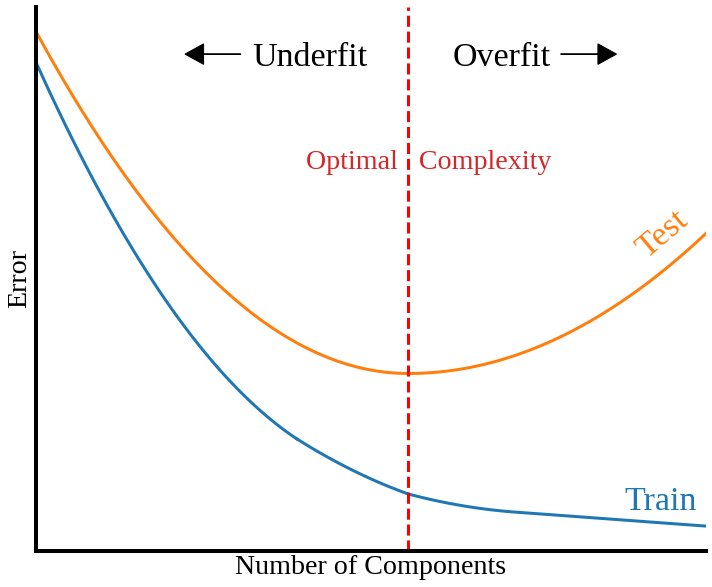

In [173]:
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 28})
plt.figure(figsize=(12,10))

x1 = np.linspace(-1,0,100)
x2 = np.linspace(0,.8,100)
plt.plot(x1,np.power((x1),2), 'tab:orange',linewidth=3)
plt.plot(x2,np.power((x2*.8),2), 'tab:orange',linewidth=3)

x1 = np.linspace(-1,-0.3,100)
x2 = np.linspace(-0.3,0,100)
x3 = np.linspace(0,0.3,100)
x4 = np.linspace(0.3,0.8,100)
plt.plot(x1,np.power((x1)*1.1,2)-.3, 'tab:blue', linewidth=3)
plt.plot(x2,np.power((x2-.4)*.7,2)-.4312, 'tab:blue', linewidth=3)
plt.plot(x3,np.power((x3-.4)*.6,2)-.4104, 'tab:blue', linewidth=3)
plt.plot(x4,-.4068-.08*(x4-.3), 'tab:blue', linewidth=3)

plt.text(-.275,0.6,'Optimal   Complexity',color='tab:red',fontsize=28)
plt.text(.6,.34,'Test',color='tab:orange',fontsize=34,rotation=40)
plt.text(.58,-.4,'Train',color='tab:blue', fontsize=34)

plt.text(-.42,.9,'Underfit',color='k', fontsize=34)
plt.text(.12,.9,'Overfit',color='k', fontsize=34)

plt.arrow(-.45, .935, -.1, 0, length_includes_head=False,
          head_width=0.06, head_length=0.05, color='black')
plt.arrow(.41, .935, .1, 0, length_includes_head=False,
          head_width=0.06, head_length=0.05, color='k')

cur_lims = [plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]]

plt.vlines([0], cur_lims[0], cur_lims[1], 'r',linestyles='--',linewidth=3)

plt.xticks([])
plt.yticks([])

plt.xlabel('Number of Components')
plt.ylabel('Error')

for axis in ['bottom','left']:
    plt.gca().spines[axis].set_linewidth(4)

for axis in ['top','right']:
    plt.gca().spines[axis].set_linewidth(0)

plt.xlim([-1,.8])
plt.ylim(cur_lims)
plt.savefig('output_data/gmm/num_comp.png',transparent=False)

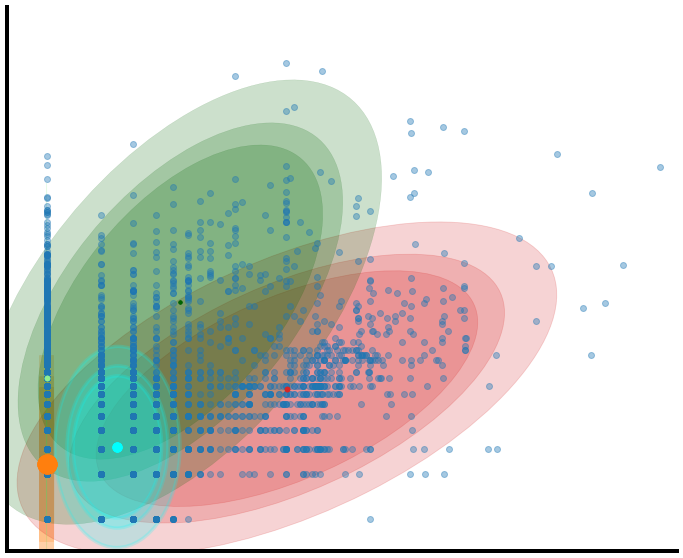

In [ ]:
from scipy.stats import chi2
import matplotlib
# partition the data of under 18 and over 18
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 20})

n_comp = 5
datas = ['comix2']
for i, data in enumerate(datas):
    # with open(f'input_data/gmm/optimal_components_{data}_log.json', 'r') as f:
    #     optimal_num_components = json.load(f)
    # ##################### read fits ####################################
    # with open(f'input_data/egos/{data}.json', 'r') as f:
    #     egos_pre = json.load(f)
    # # reduce egos to 2 dimensions 
    # egos = [{'age': 0 if ego['age'] < 2 else 1, 'contacts': [sum(ego['contacts'][:3]), sum(ego['contacts'][3:])], 'degree': ego['degree']} for ego in egos_pre]
    # classifier = []
    # samples = []
    # for l in [0,1]:
    #     classifier.append(sklearn.mixture.GaussianMixture(n_components=n_comp, covariance_type='full'))
    #     egos_age = [a for a in egos if a['age'] == l]
    #     print(len(egos_pre), len(egos_age))
    #     ## use log(k+1) instead of k to fit
    #     X = [[math.log(b+1) for b in a['contacts']] for a in egos_age]
    #     classifier[l].fit(X)
        
    #     centers, cov, weights = [], [], []
    #     for center in classifier[-1].means_:
    #         centers.append(center)
    #     for covariance in classifier[-1].covariances_:
    #         cov.append(covariance)
    #     for weight in classifier[-1].weights_:
    #         weights.append(weight)
            
        # print(centers)
        # print(cov)
        # print(weights)
        
        # centers, cov, weights = np.array(centers), np.array(cov), np.array(weights)
        # fig, ax = plt.subplots(1,1,figsize=(12,10))

        # ####################### each elipse plotted #######################
        # # Calculate scaling factor for 95% confidence interval
        # confidence_level = 0.95
        # scale = np.sqrt(chi2.ppf(confidence_level, df=2))

        # # Plot confidence ellipses
        # for i, (center, cov, weight) in enumerate(zip(centers, cov, weights)):
        #     # Calculate eigenvalues and eigenvectors
        #     eigvals, eigvecs = np.linalg.eigh(cov)
        #     order = eigvals.argsort()[::-1]
        #     eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            
        #     # Calculate ellipse orientation
        #     angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            
        #     # Calculate ellipse dimensions
        #     width, height = 2 * scale * np.sqrt(eigvals)
            
        #     # Create ellipse with weight-proportional linewidth
        #     lw = 20*weight
        #     ellipse = matplotlib.patches.Ellipse(center, width, height, angle=angle,
        #                         edgecolor='blue', facecolor='none',
        #                         linewidth=lw, linestyle='-')
        #     ax.add_patch(ellipse)
            
        #     # Plot component centers
        #     ax.scatter(center[0], center[1], s=500*weight, c='red', zorder=2)
        
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    
    # saved values so we do not have to rerun the process every time
    centers = [[0.       , 0.8497018], [3.05072964, 2.03610064], [0.        , 2.20829167], [1.69797138, 3.38907142], [0.89931593, 1.12356798]]
    cov = [[[1.00000000e-06, 0.00000000e+00],[0.00000000e+00, 3.15110863e-01]], 
        [[1.27380924, 0.54578293],[0.54578293, 0.73737824]], 
        [[1.00000000e-06, 0.00000000e+00],[0.00000000e+00, 1.00378173e+00]], 
        [[0.70906735, 0.53888079],[0.53888079, 1.31077431]], 
        [[0.06852359, 0.00139266],[0.00139266, 0.2684105 ]]]
    weights = [0.7329802032821193, 0.039986349461309925, 0.04062543879673585, 0.01732260847931158, 0.16908539998037048]
    colours = ['tab:orange', 'tab:red', 'lightgreen', 'darkgreen', 'cyan']
    for i, (center, cov, weight) in enumerate(zip(centers, cov, weights)):
        for confidence_level in [0.9,0.95,0.99]:
            scale = np.sqrt(chi2.ppf(confidence_level, df=2))
            eigvals, eigvecs = np.linalg.eigh(cov)
            order = eigvals.argsort()[::-1]
            eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            
            # Calculate ellipse orientation
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            
            # Calculate ellipse dimensions
            width, height = 2 * scale * np.sqrt(eigvals)
            
            # Create ellipse with weight-proportional linewidth
            lw = 20*weight
            ellipse = matplotlib.patches.Ellipse(center, width, height, angle=angle,
                                edgecolor=colours[i], facecolor=colours[i],
                                linewidth=lw, linestyle='-',alpha=0.2)
            ax.add_patch(ellipse)
            
            # Plot component centers
            ax.scatter(center[0], center[1], s=500*weight, c=colours[i], zorder=2)
    
    
    ax.scatter([a[0] for a in X], [a[1] for a in X],color='tab:blue',alpha=0.4, zorder=1)
    ax.set_xlim([-.5,8])
    ax.set_ylim([-.5,8])
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(4)

    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
    # plt.scatter([a[0] for a in centers], [a[1] for a in centers], color='red')
    plt.savefig('output_data/gmm/fitting.png')
    plt.show()
    
### maybe try a fake example to make it more obvious


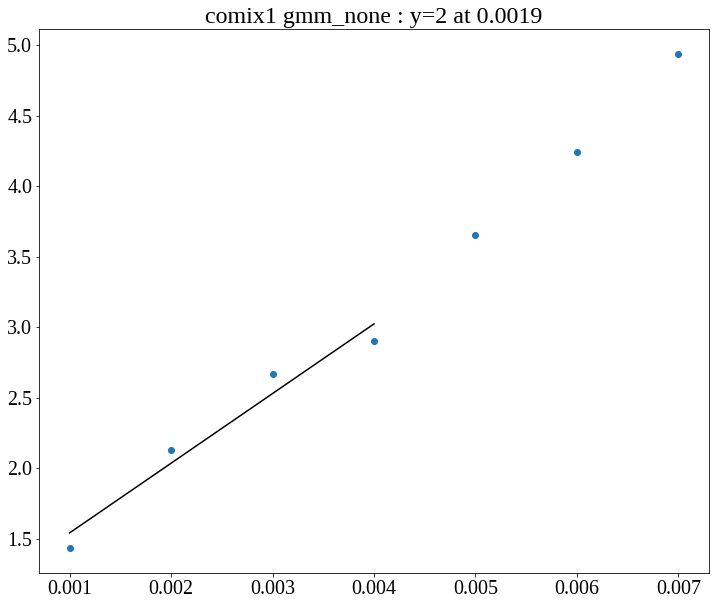

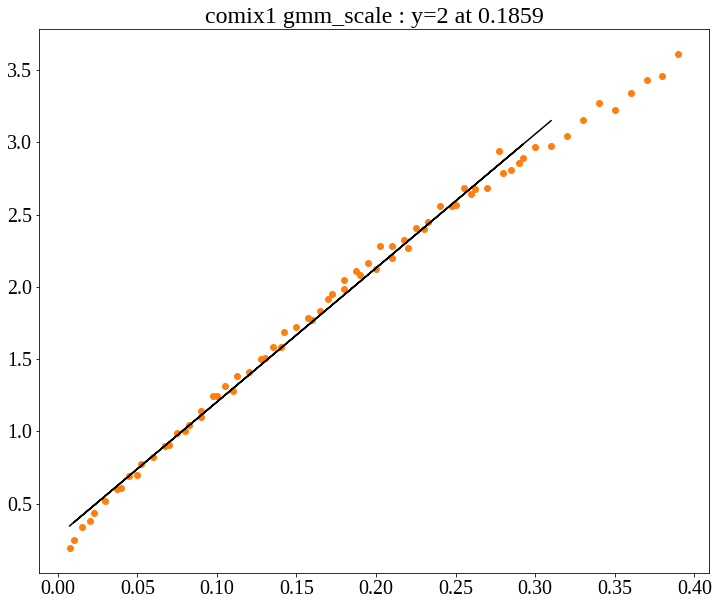

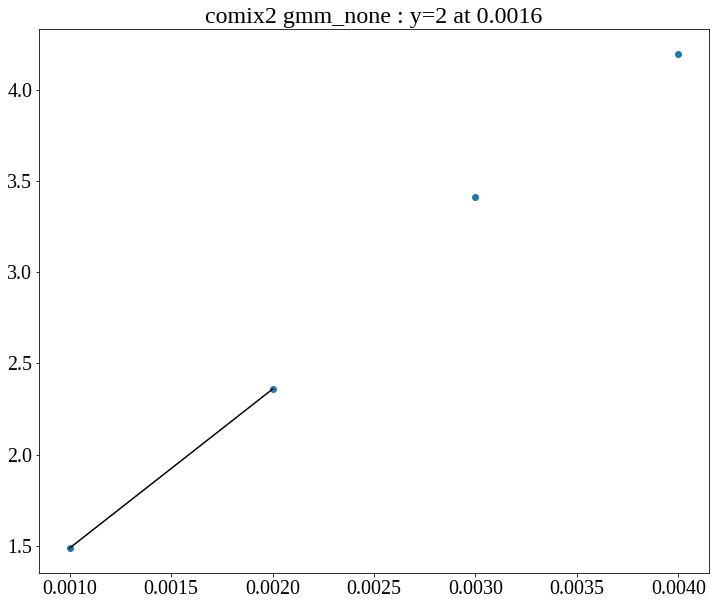

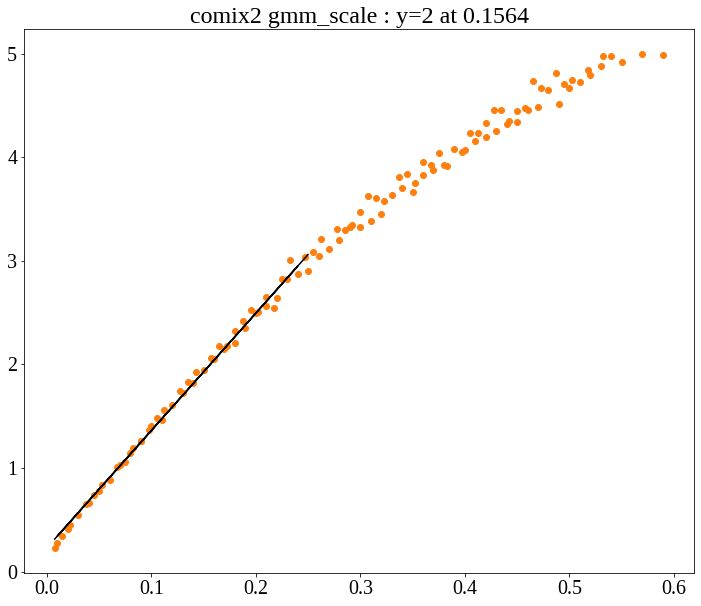

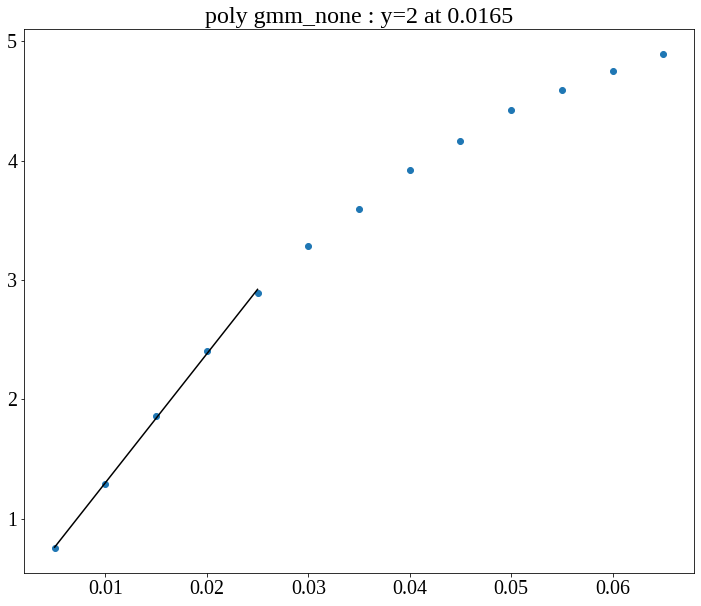

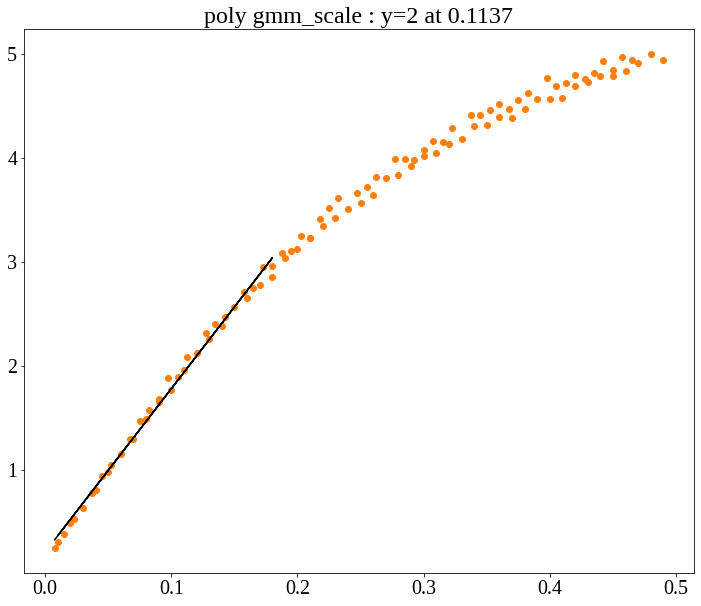

In [172]:
## r0 vs beta
from sklearn.linear_model import LinearRegression
datas = ['comix1', 'comix2', 'poly']
models = ['gmm_none', 'gmm_scale']
colours=['tab:blue','tab:orange']
for data_idx, data in enumerate(datas):
    for model_idx, model in enumerate(models):
        plt.figure(figsize=(12,10))
        overall = {}
        for params in [0,1]:
            for network_idx in range(60):
                # print(data,model,params,network_idx)
                try:
                    with open(f'output_data/gmm/{params}_{network_idx}_{data}_{model}.json','r') as f:
                        res = json.load(f)
                    if model_idx == 0:
                        taus = [np.arange(0.001,0.03,0.001),
                                np.arange(0.001,0.03,0.001),
                                np.arange(0.005,0.11,0.005)]
                    else:
                        if params == 0:
                            taus = [np.arange(0.0005,0.02,0.0005),
                                    np.arange(0.0005,0.15,0.0005),
                                    np.arange(0.0005,0.10,0.0005)]
                            taus = [[15*x for x in a] for a in taus]
                        else:
                            taus = [np.arange(0.0005,0.02,0.0005),
                                    np.arange(0.0005,0.15,0.0005),
                                    np.arange(0.0005,0.10,0.0005)]
                            taus = [[20*x for x in a] for a in taus]
                    y = [[a for a in b if a>=0] for b in res['r0_1']]
                    x = [a for i, a in enumerate(taus[data_idx]) if len(y[i])]
                    if len([np.mean(a) for a in y if len(a)>0]) != len(x):
                        continue
                    y = [np.mean(a) for a in y if len(a)>0]
                    # plt.scatter(x,[np.mean(a) for a in y if len(a)>0],color=colours[model_idx])
                    for i, beta in enumerate(x):
                        if beta in overall.keys():
                            overall[beta].append(y[i])
                        else:
                            overall[beta] = [y[i]]
                except:
                    tmp =True
        keys = overall.keys()
        y = [np.mean(overall[key]) for key in keys]
        x = [key for key in keys]
        x, y = [a for i,a in enumerate(x) if y[i] < 5], [a for a in y if a<5]        
        plt.scatter(x,y,color=colours[model_idx])
        ## reduce to body to get line of best fit
        x, y = [a for i,a in enumerate(x) if y[i] < 3], [a for a in y if a<3]
        m = LinearRegression()
        m.fit(np.array(x).reshape(-1,1), y)
        y_pred = m.predict(np.array(x).reshape(-1,1))
        plt.plot(x,y_pred,'k')
        plt.title(f'{data} {model} : y=2 at {np.round((2-m.intercept_)/m.coef_[0],4)}')
        plt.show()
